In [1]:
import pandas as pd, numpy as np
from matplotlib import pyplot as plt
import datetime
import scipy.signal as sig
import scipy.interpolate as inpl
import scipy.optimize as opt 
%matplotlib inline

# Load data

In [2]:
parser = lambda x: pd.datetime.strptime(x, '%Y-%m-%d %H:%M:%S')
DF = pd.read_csv('vh', parse_dates=['timestamp'], date_parser=parser)

In [3]:
DF.head()

,timestamp,liters,id
0,2019-03-01 03:00:15,0,d28378aec6bd1214b87047f2af506f70
1,2019-03-01 03:01:25,0,d28378aec6bd1214b87047f2af506f70
2,2019-03-01 03:02:35,0,d28378aec6bd1214b87047f2af506f70
3,2019-03-01 03:03:45,0,d28378aec6bd1214b87047f2af506f70
4,2019-03-01 03:04:55,0,d28378aec6bd1214b87047f2af506f70


In [4]:
print('Amount of cars:', len(set(DF['id'])))

Amount of cars: 30


# Get test car

In [86]:
cars = list(set(DF['id']))

In [188]:
test_car= DF[DF['id']=='beeece2860b1da0982db4528982046a4'].reset_index(drop=True).copy()
test_car.head()

,timestamp,liters,id
0,2019-03-01 04:11:47,362,beeece2860b1da0982db4528982046a4
1,2019-03-01 04:12:07,362,beeece2860b1da0982db4528982046a4
2,2019-03-01 04:13:17,362,beeece2860b1da0982db4528982046a4
3,2019-03-01 04:14:27,362,beeece2860b1da0982db4528982046a4
4,2019-03-01 04:15:37,362,beeece2860b1da0982db4528982046a4


In [189]:
# remove duplicates by timestamp
test_car = test_car.drop_duplicates('timestamp').reset_index(drop=True)

In [190]:
test_car.insert(2,'day', test_car['timestamp'].apply(lambda x:x.day))

# Plot by day

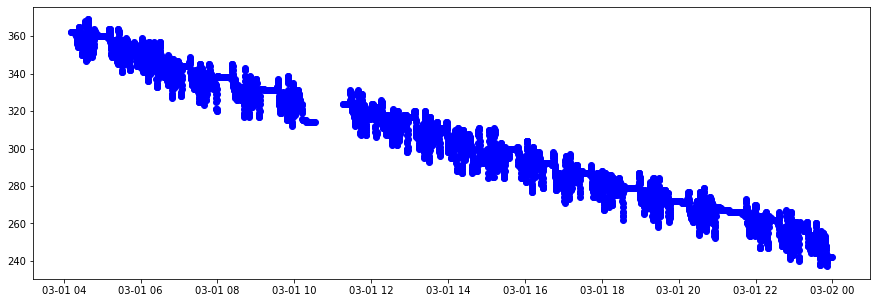

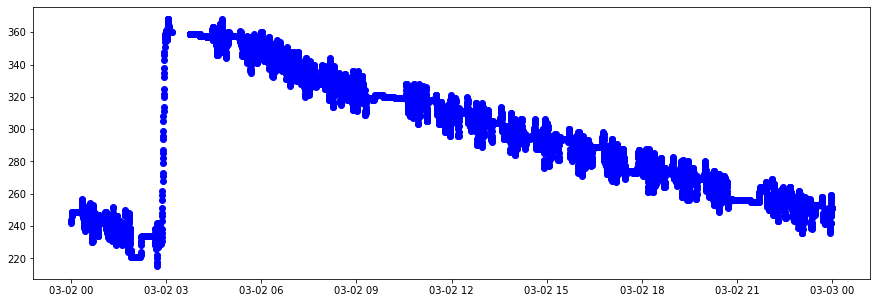

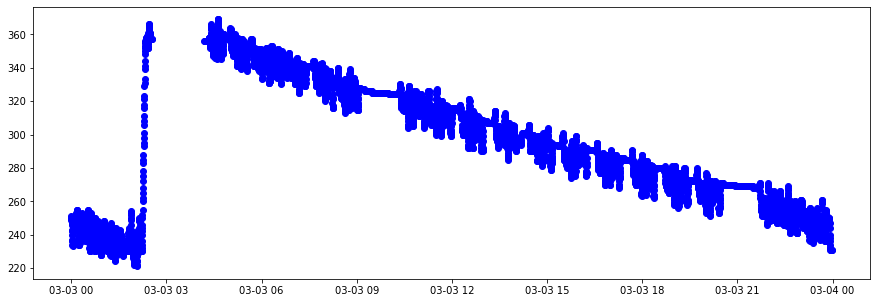

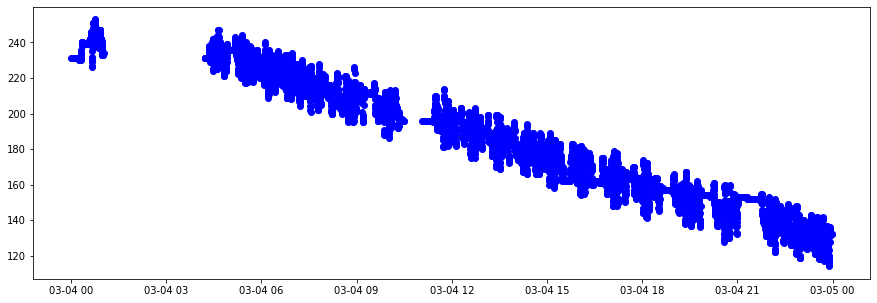

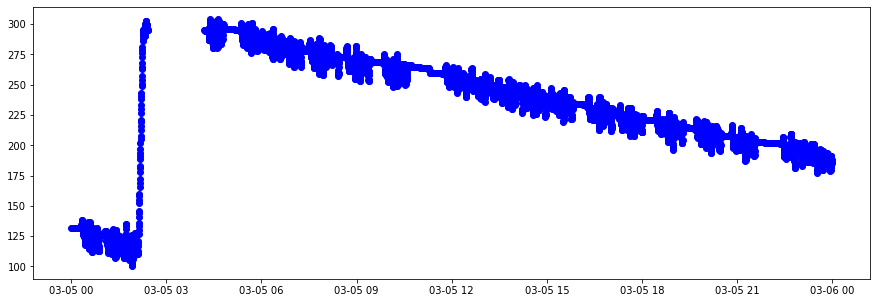

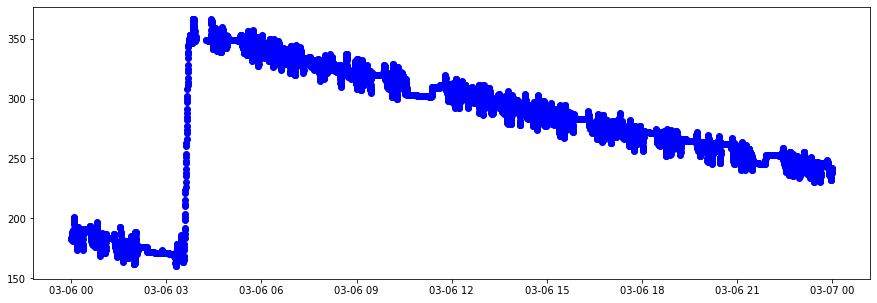

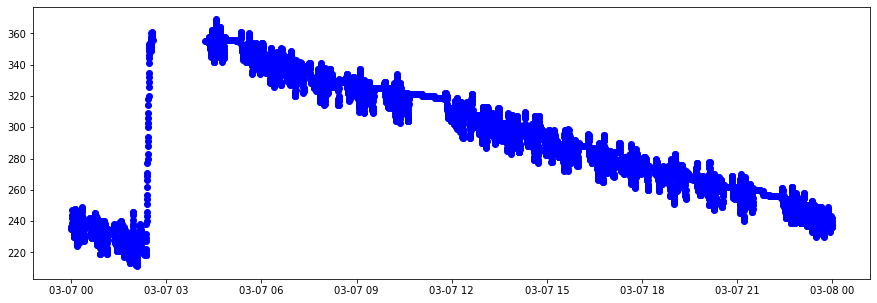

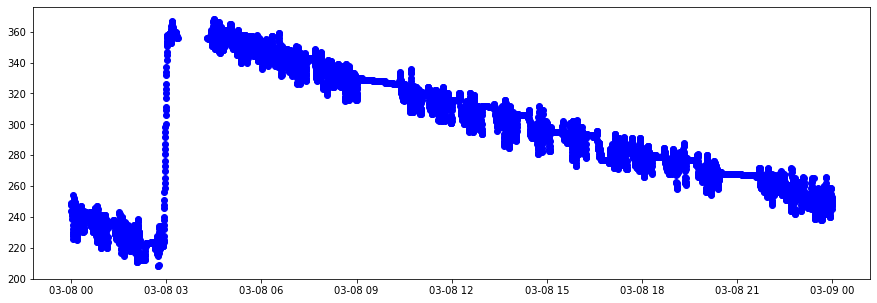

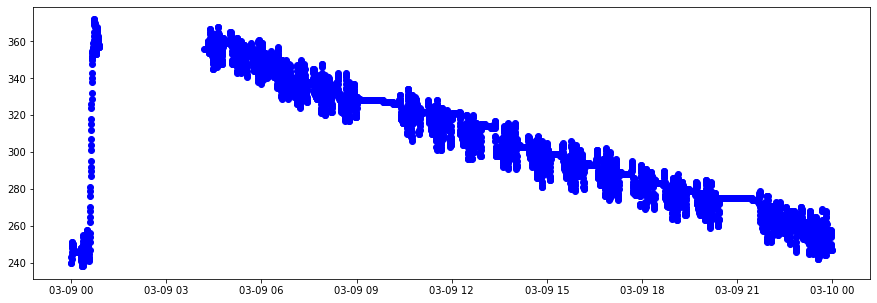

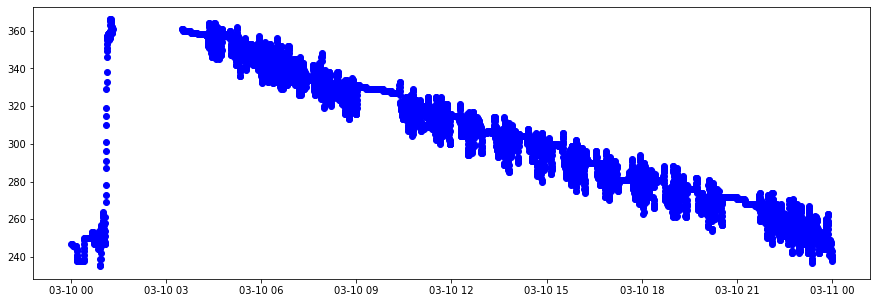

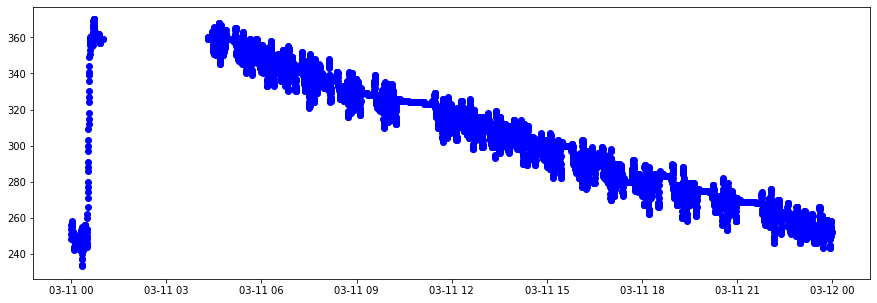

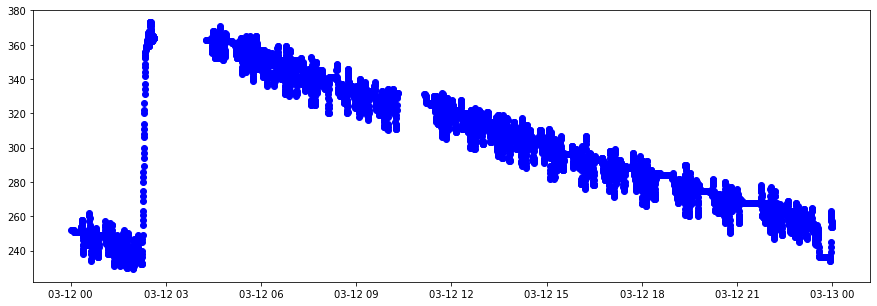

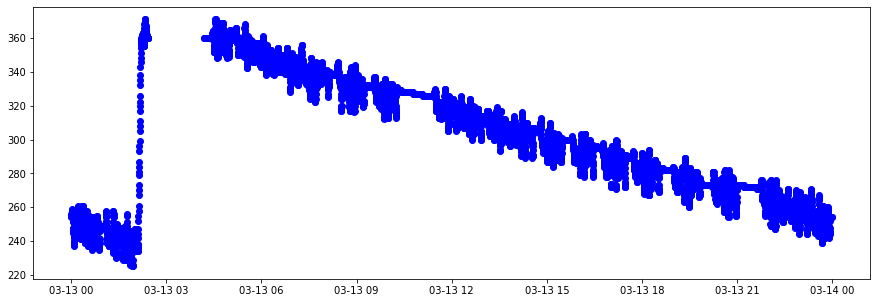

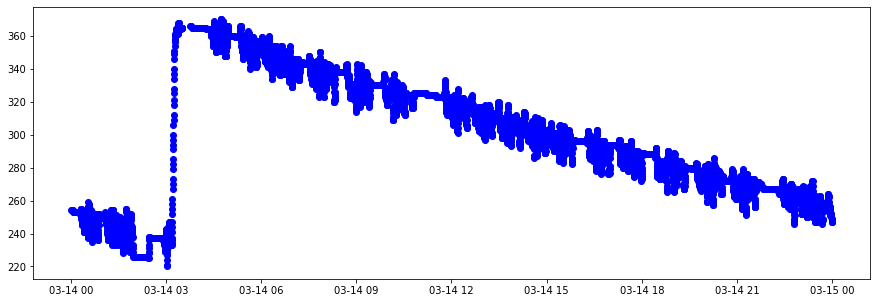

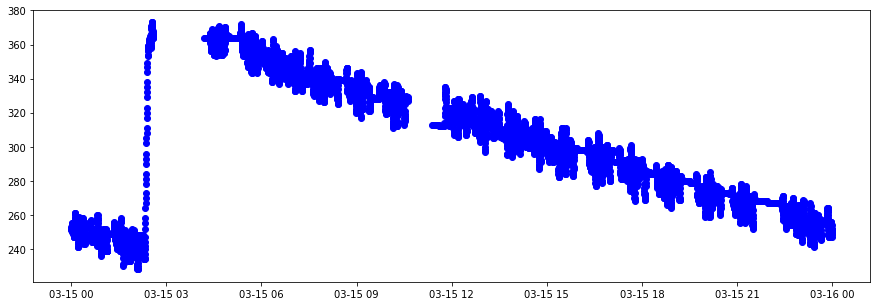

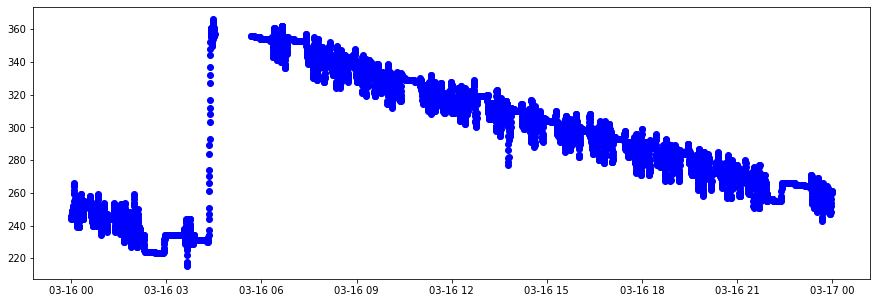

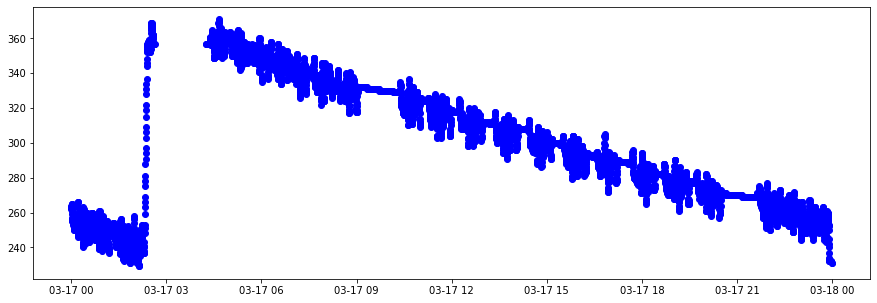

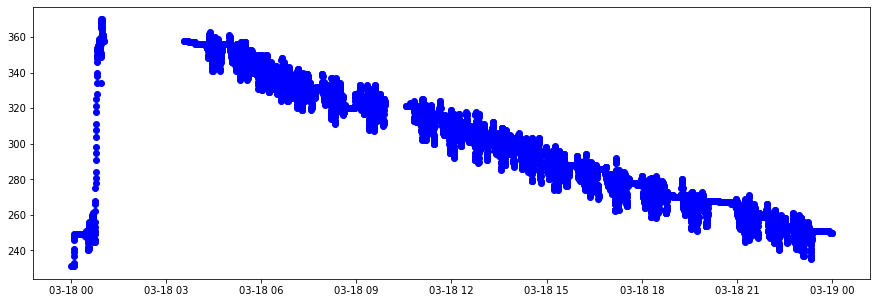

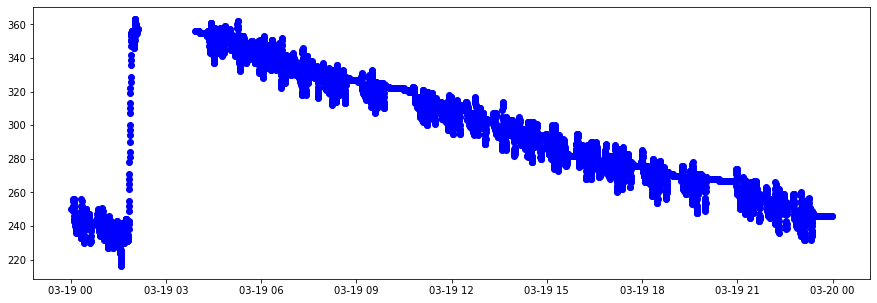

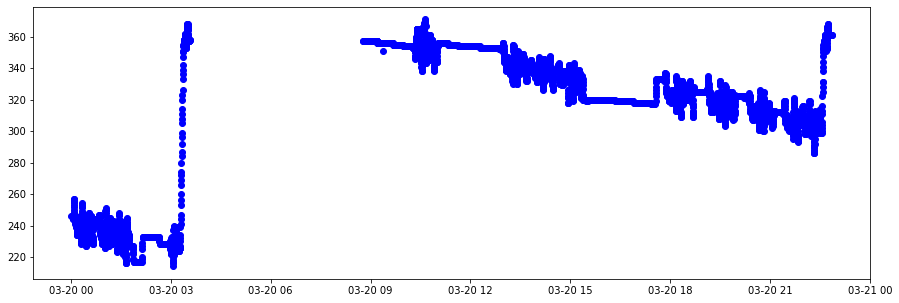

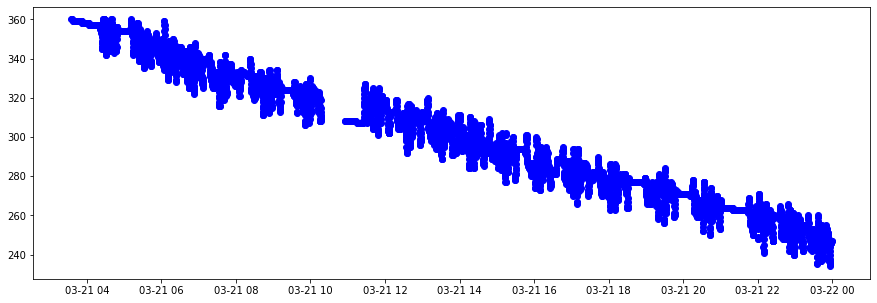

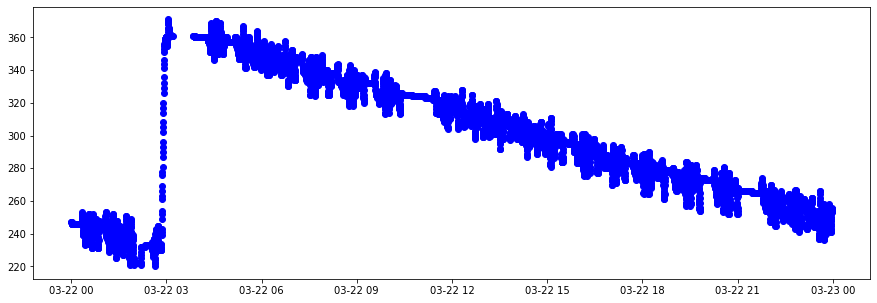

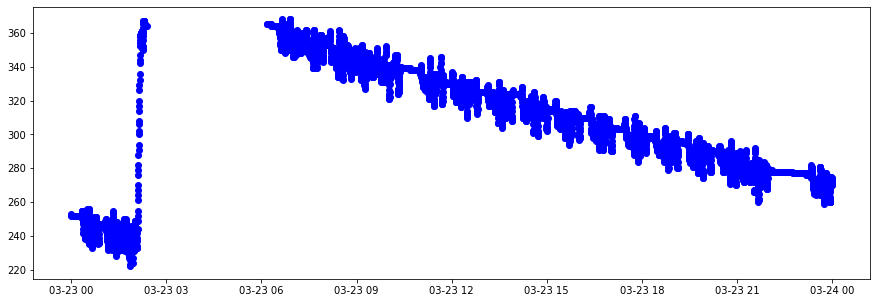

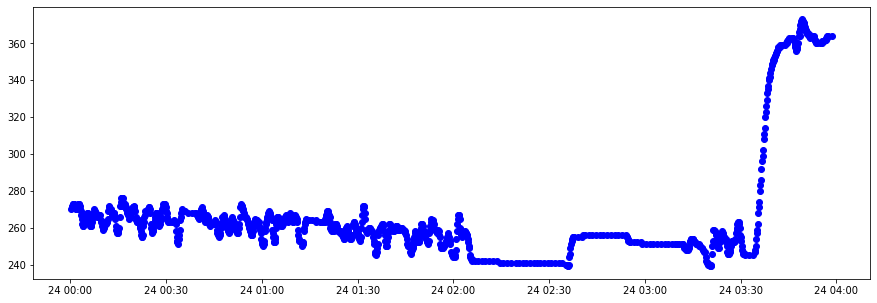

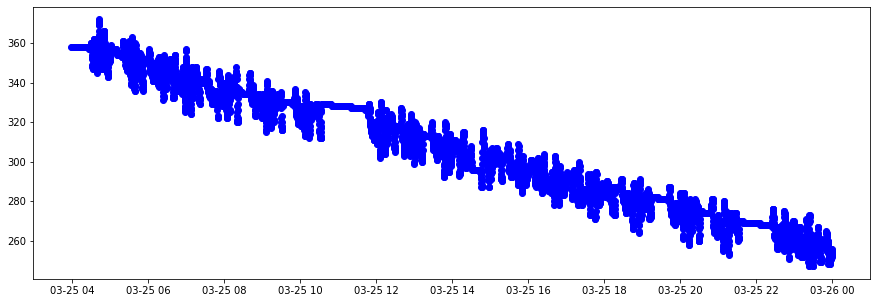

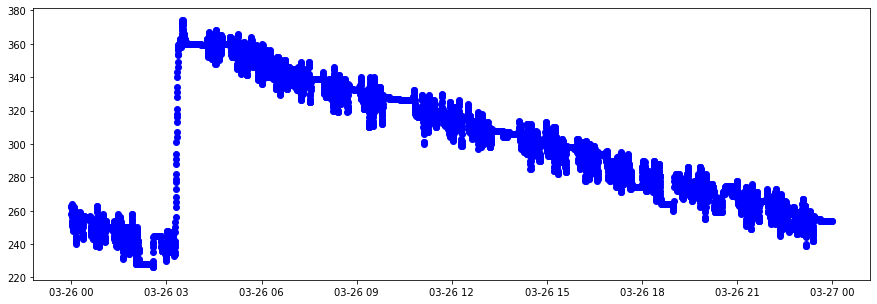

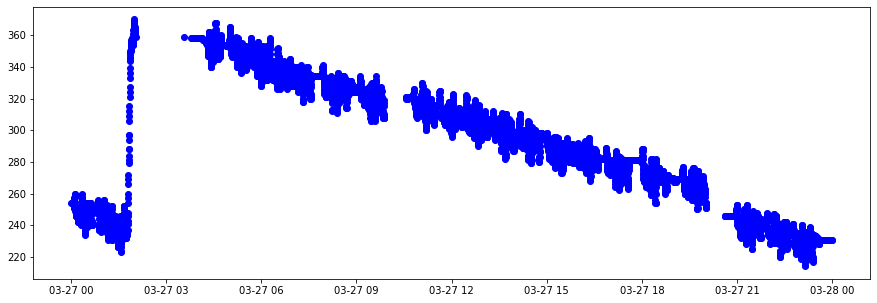

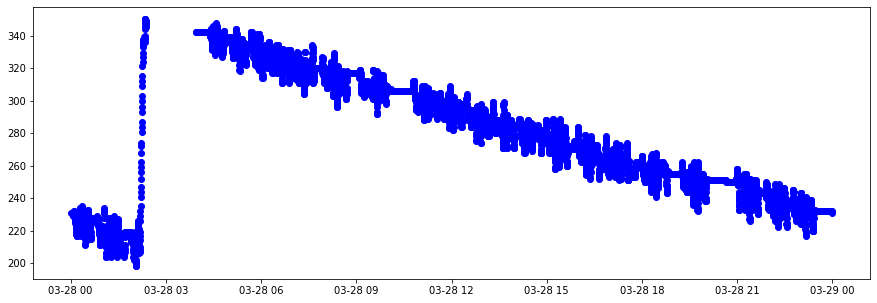

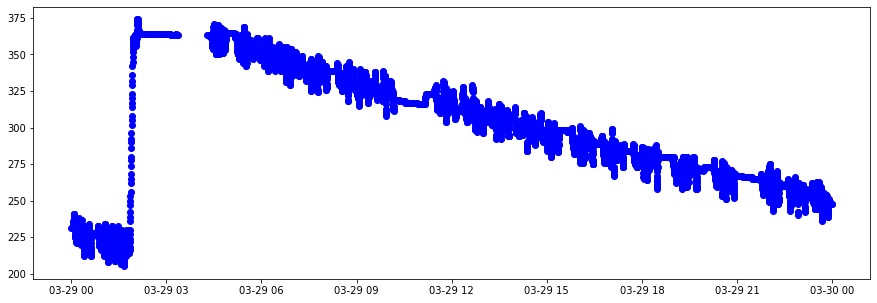

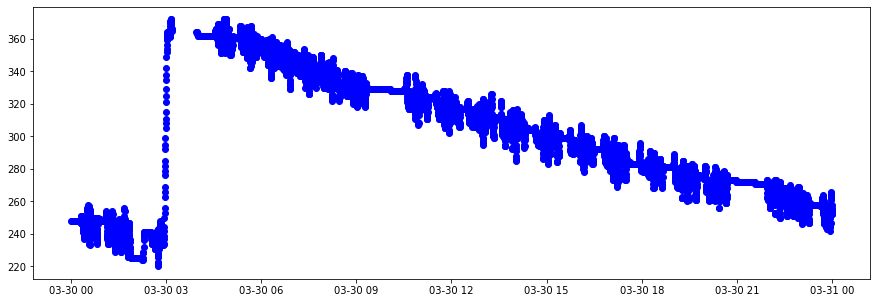

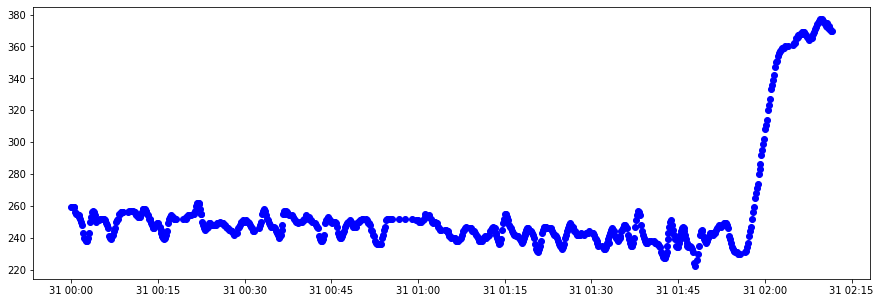

In [191]:
by_day = test_car.groupby('day')
for g_name in by_day.groups:
    a = by_day.get_group(g_name)
    plt.figure(figsize=(15,5))
    plt.plot(a['timestamp'], a['liters'], 'bo')
    
    plt.show()

# Tasks

1. Определить временные диапазоны:
    * простоя (когда данные не поступали)
    * расходования топлива (интервалы между заправками??)
    * заправки топливом (резкий скачок вверх)
    
2. Определить количество заправленного топлива для каждой заправки

3. Найти сливы топлива

4. Определить среднесуточный расход топлива для каждого ТС за период данных в файле

# Find gaps

In [192]:
diff = np.diff(test_car['timestamp'])

In [193]:
gap_thresh = np.timedelta64(10,'m')
gaps_start_idx = np.argwhere(diff > gap_thresh).flatten()
gaps_end_idx = gaps_start_idx+1

In [194]:
idx_to_plot = set(np.hstack([gaps_start_idx, gaps_end_idx]))

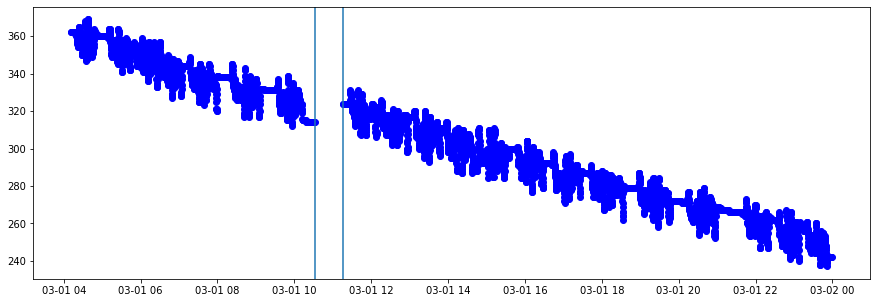

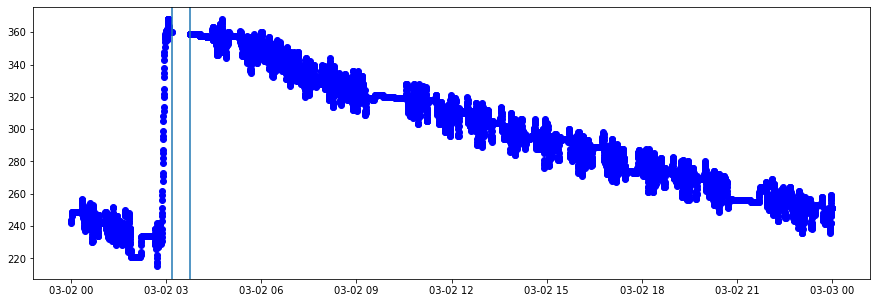

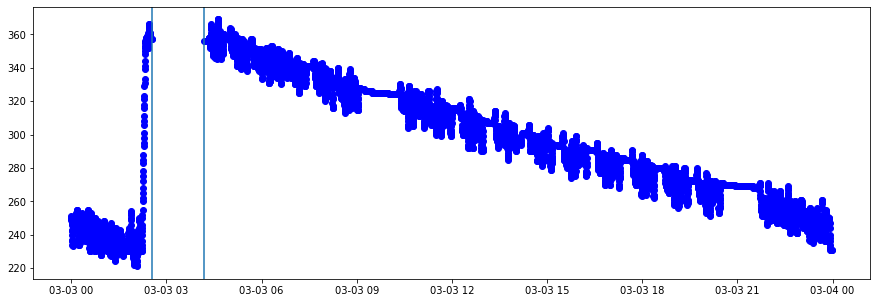

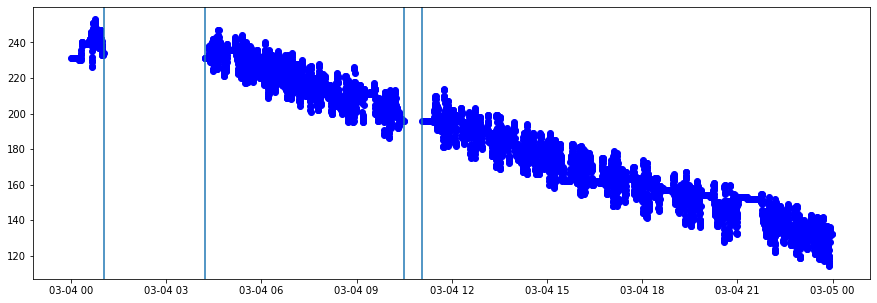

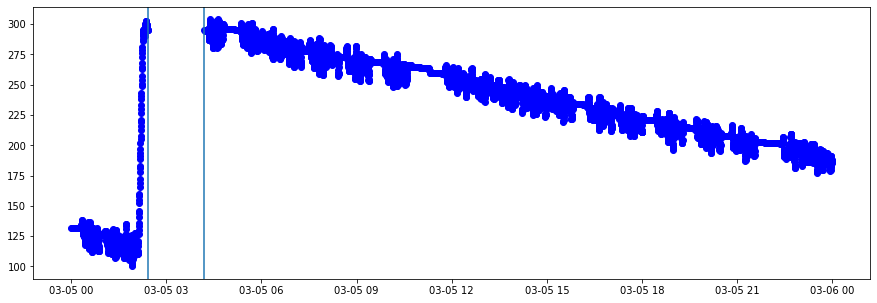

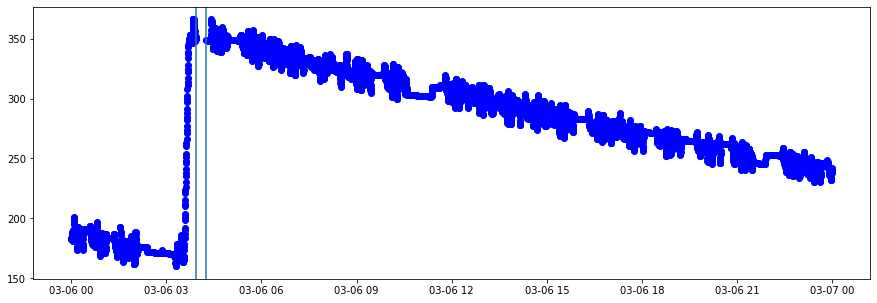

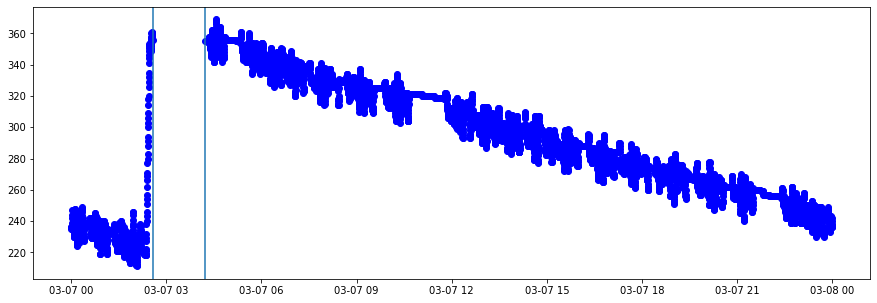

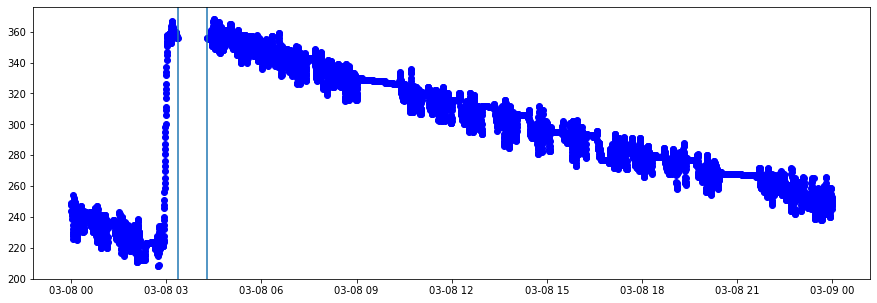

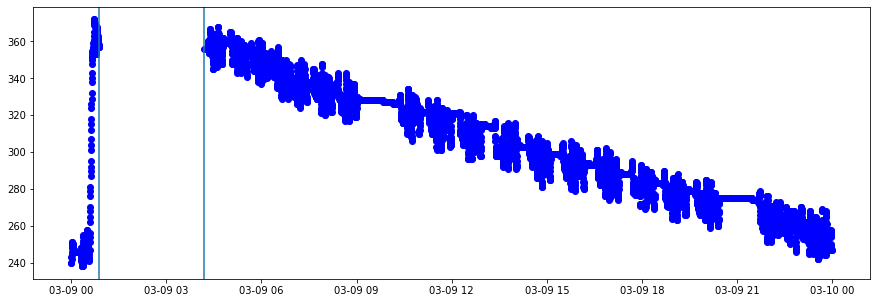

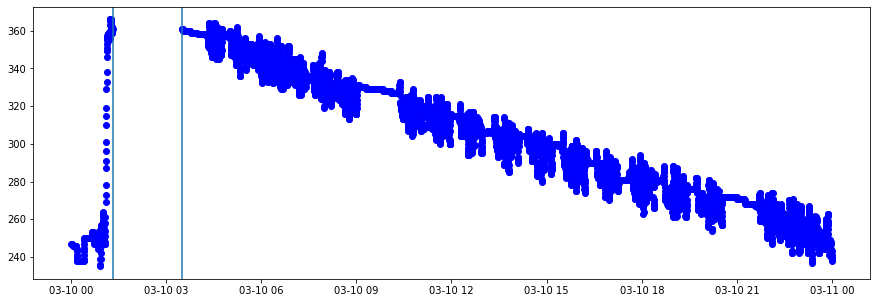

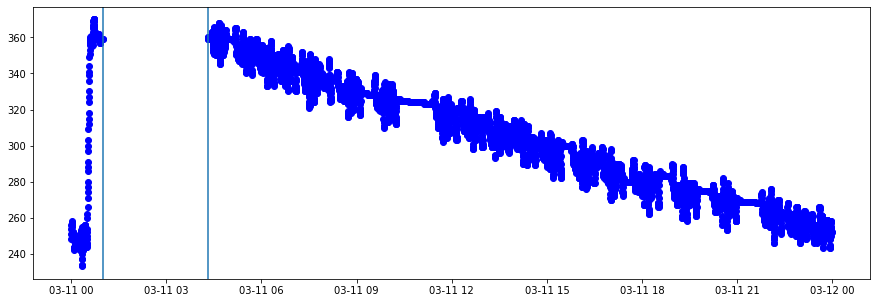

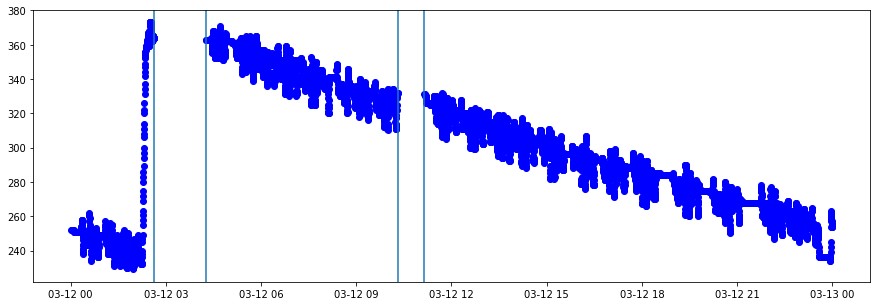

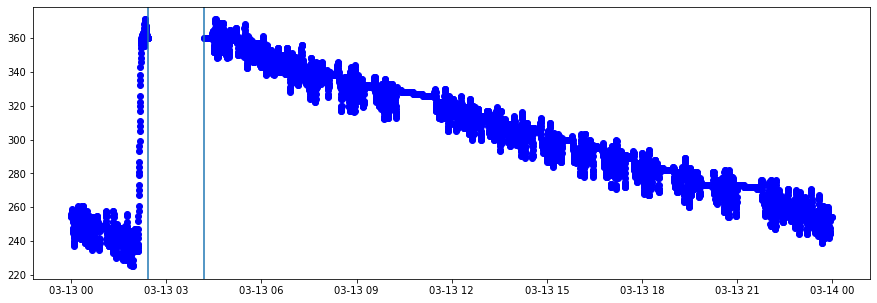

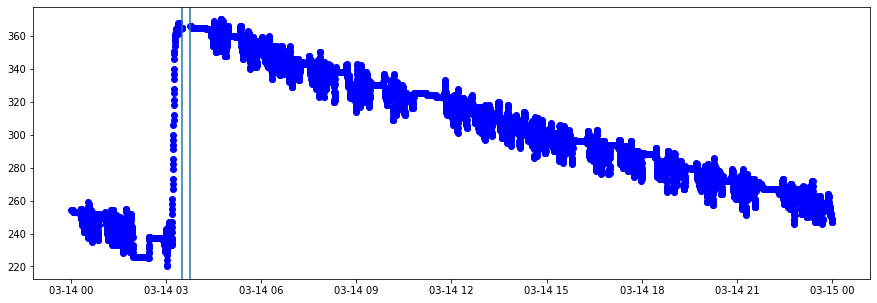

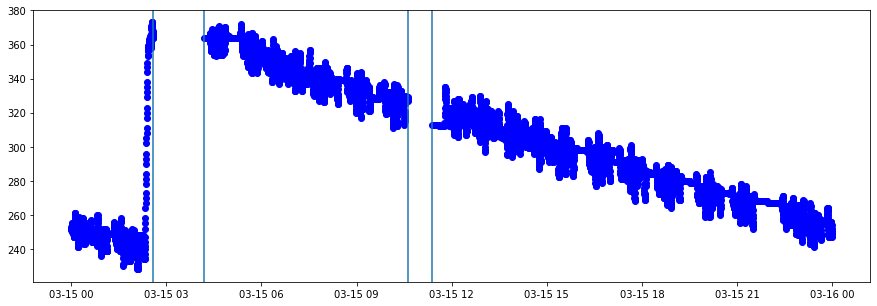

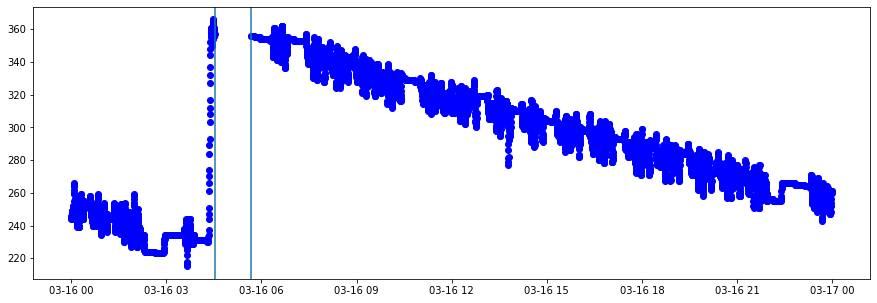

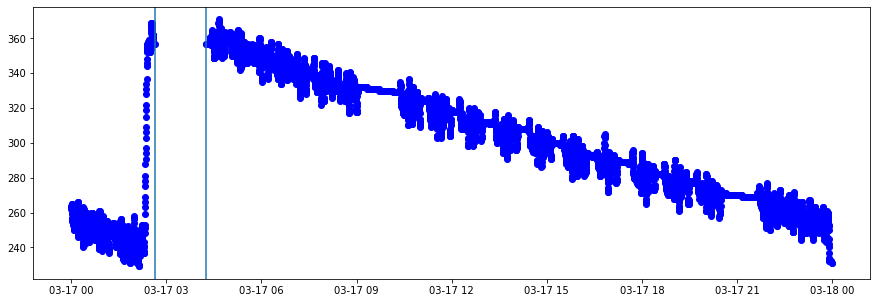

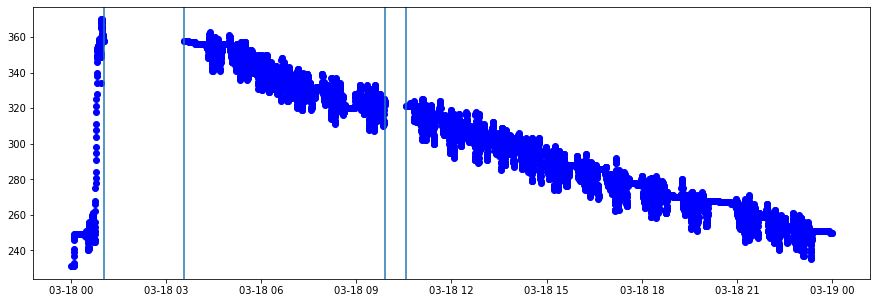

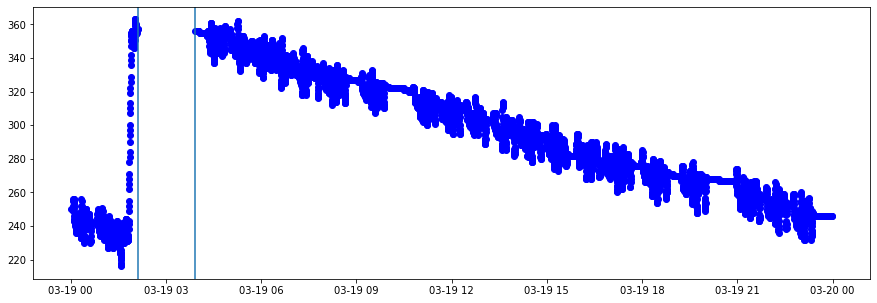

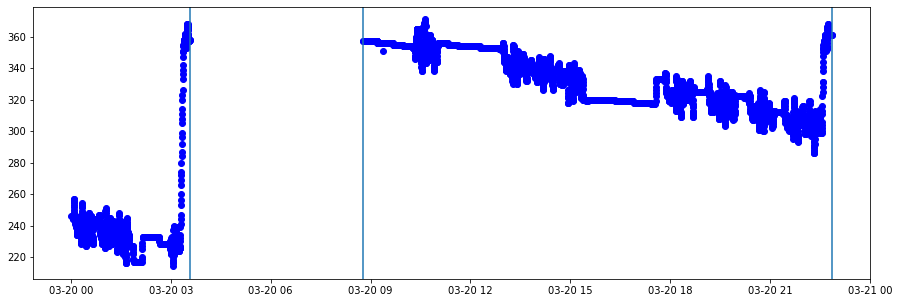

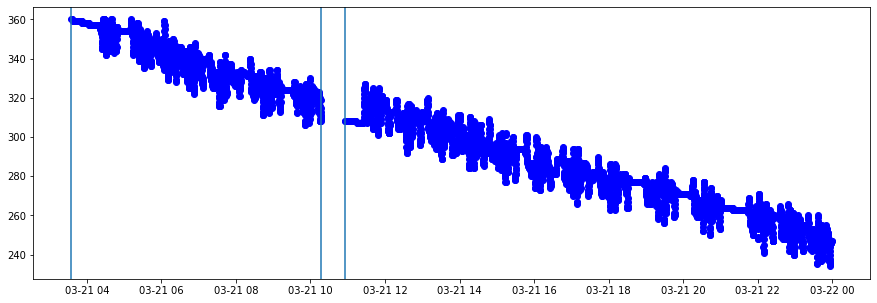

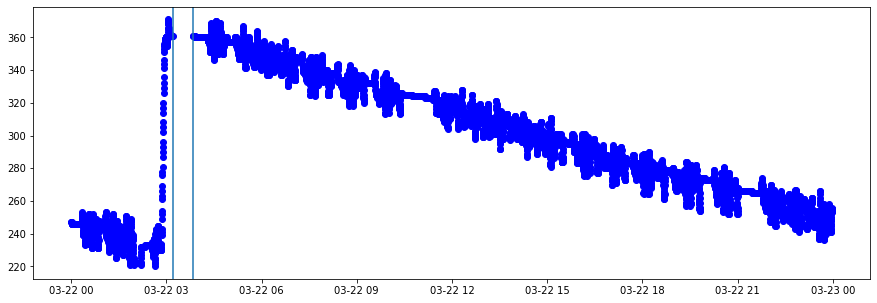

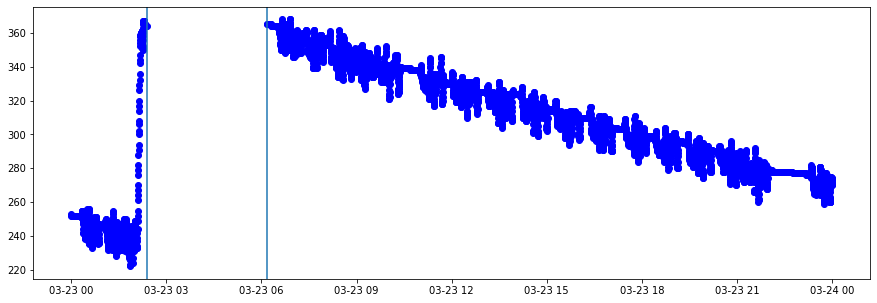

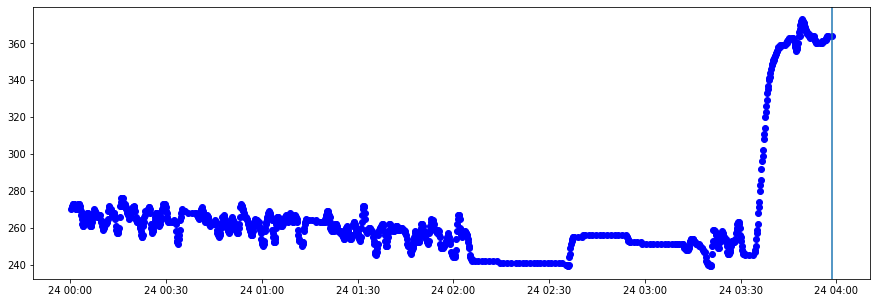

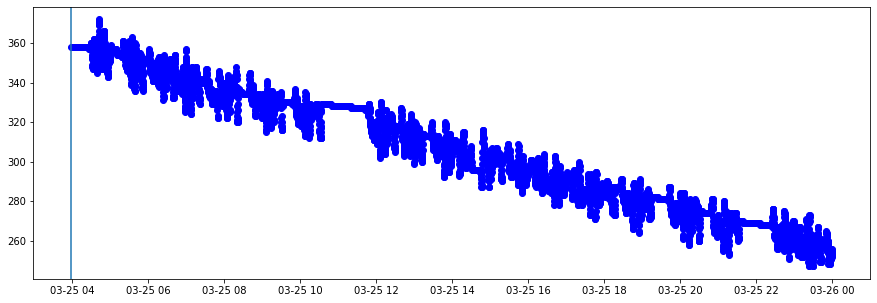

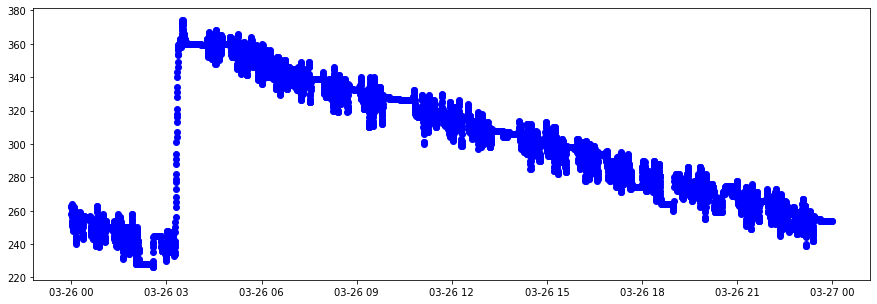

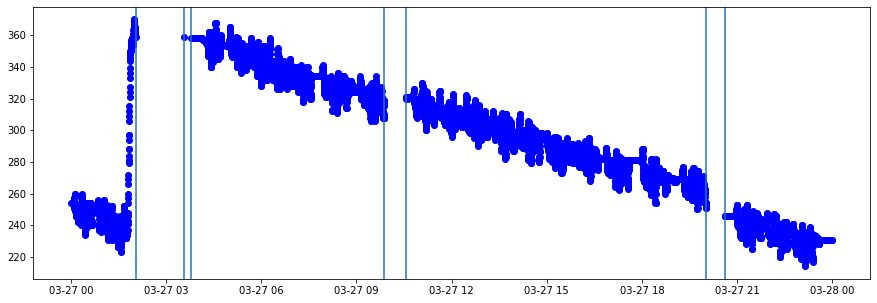

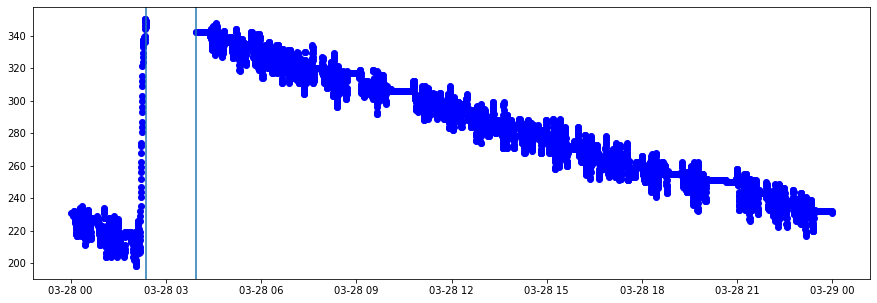

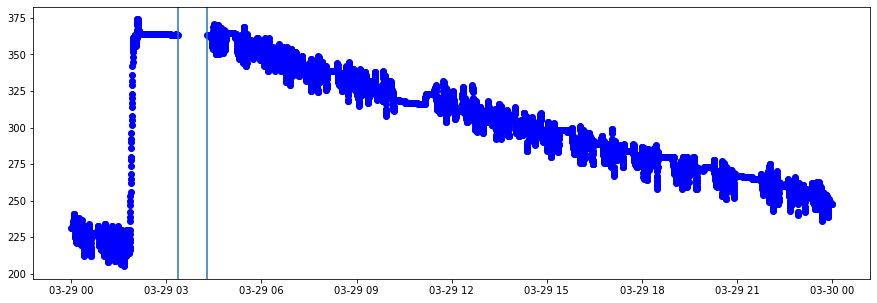

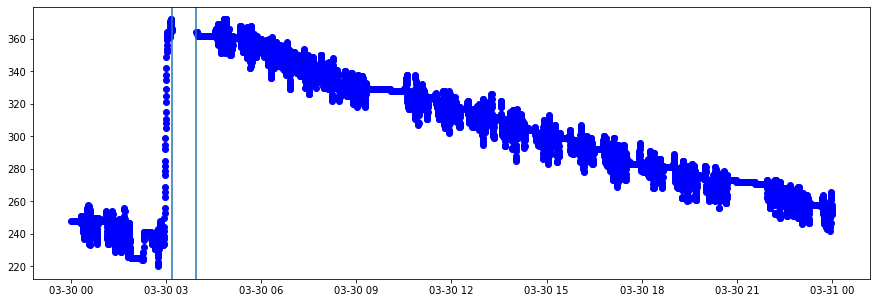

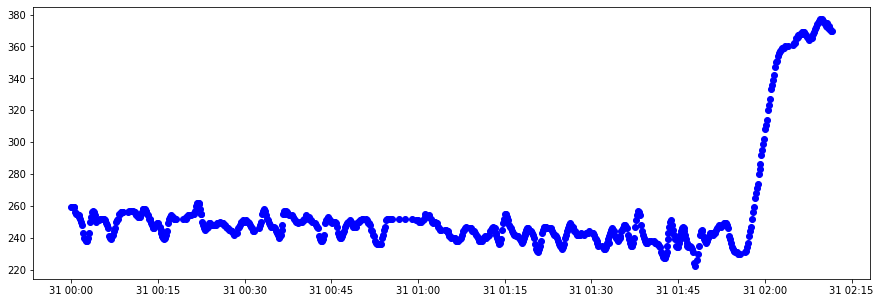

In [195]:
by_day = test_car.groupby('day')
for g_name in by_day.groups:
    a = by_day.get_group(g_name)
    plt.figure(figsize=(15,5))
    plt.plot(a['timestamp'], a['liters'], 'bo')
        
    for i in idx_to_plot.intersection(a.index):
        plt.axvline(x=a.loc[i,'timestamp'])
            
    plt.show()

In [196]:
# create table with gaps
start = test_car.loc[gaps_start_idx,'timestamp'].reset_index(drop=True)
end = test_car.loc[gaps_end_idx,'timestamp'].reset_index(drop=True)
data = [start,end]
gaps = pd.DataFrame(data, index = ['start', 'end']).T

In [197]:
gaps['duration'] = gaps['end'] - gaps['start']

In [198]:
gaps

,start,end,duration
0,2019-03-01 10:32:14,2019-03-01 11:15:28,0 days 00:43:14
1,2019-03-02 03:11:42,2019-03-02 03:44:48,0 days 00:33:06
2,2019-03-03 02:33:12,2019-03-03 04:10:57,0 days 01:37:45
3,2019-03-04 01:02:24,2019-03-04 04:13:04,0 days 03:10:40
4,2019-03-04 10:30:02,2019-03-04 11:04:32,0 days 00:34:30
5,2019-03-05 02:25:58,2019-03-05 04:11:14,0 days 01:45:16
6,2019-03-06 03:55:54,2019-03-06 04:14:35,0 days 00:18:41
7,2019-03-07 02:33:56,2019-03-07 04:13:57,0 days 01:40:01
8,2019-03-08 03:21:26,2019-03-08 04:16:21,0 days 00:54:55
9,2019-03-09 00:53:12,2019-03-09 04:12:05,0 days 03:18:53


# Find refill

1. Сгладить сигнал   
    Протестированные методы:

    * np.polifit - плохой результат
    * sm.nonparametric.lowess - хороший результат, но при заправках превращает сигнал в гиперболу
    * np.window + np.convolve - средний результат
    * scipy.curve_fit - средний результат
    * scipy.signal.savgol_filter - хороший результат, но появляются выбросы на вершинах
    * rolling + np.linalg.lstsq - хороший результат, но долго считать
    * sm.ols - плохой результат
    

2. Найти производную

3. Найти пики производной

### Normalize frequency

In [199]:
norm_freq = test_car.set_index('timestamp').resample('T').fillna('backfill').copy()
sum(norm_freq['liters'].isna())

0

### Median filtering

In [200]:
# add values to process right boundary
ext_value = norm_freq['liters'][:5].mean()
ext_row = norm_freq.reset_index().iloc[-1, :]
ext_row['liters'] = ext_value
data = np.repeat([ext_row.values], repeats=50, axis=0)
ext_df = pd.DataFrame(data[:,1:], columns=norm_freq.columns, index=data[:,0])
norm_freq_ext = norm_freq.append(ext_df)

In [201]:
norm_freq_ext.insert(3, 'med_liters', norm_freq_ext['liters'].rolling(101, center=True).median())
norm_freq_ext.fillna(method = 'backfill', inplace=True)
norm_freq_ext.fillna(method = 'pad', inplace=True)

### Rolling mean filtering

In [202]:
clean_sig = norm_freq_ext[["med_liters"]].rolling(40).mean().fillna(method='backfill')

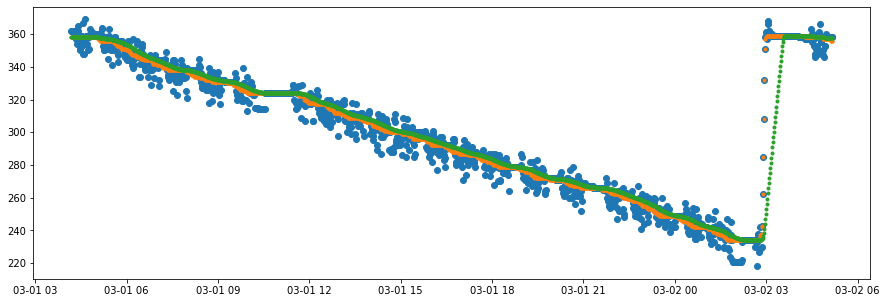

In [203]:
plt.figure(figsize=(15,5))
plt.plot(norm_freq_ext['liters'][:1500],'o', norm_freq_ext['med_liters'][:1500],'.', clean_sig[:1500],'.')
plt.show()

### Compute derivative

In [204]:
d1 = clean_sig['med_liters'].values.flatten()
d2 = clean_sig['med_liters'].shift(-10).fillna(method = 'pad').values.flatten()
derivative = d2-d1

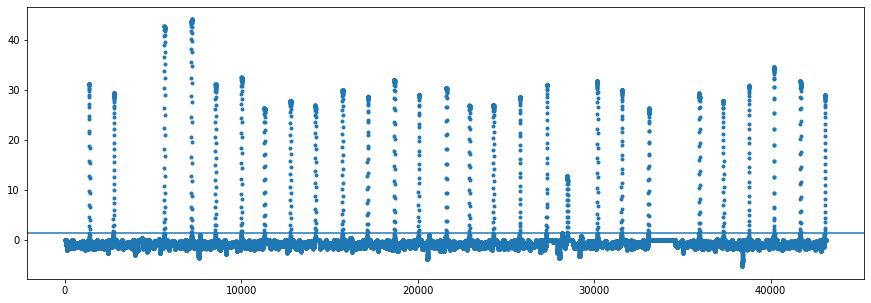

In [205]:
plt.figure(figsize=(15,5))
plt.plot(derivative[:],'.')
plt.axhline(y=1.5)
plt.show()

In [206]:
peaks = sig.find_peaks(derivative, 5 ,width = 20)

In [207]:
refills_start = peaks[1]['left_ips'] -10
refills_end = peaks[1]['right_ips'] -10

In [208]:
idx_to_plot = np.hstack([refills_start, refills_end]).astype(int)
idx_to_plot = norm_freq_ext.index.to_series()[idx_to_plot].drop_duplicates()

In [209]:
# debug plot
# norm_freq_ext['clean_sig'] = clean_sig
# by_day = norm_freq_ext.groupby('day')
# for g_name in by_day.groups:
#     a = by_day.get_group(g_name)
#     plt.figure(figsize=(15,5))
#     plt.plot(a.index, a['liters'], 'o')    
#     plt.plot(a.index, a['med_liters'], '.')    
#     plt.plot(a.index, a['clean_sig'], '.')

#     for i in idx_to_plot:
#         if a.index.min()-pd.DateOffset(minutes=15) < i <a.index.max()+pd.DateOffset(minutes=15):
#             plt.axvline(x=i)

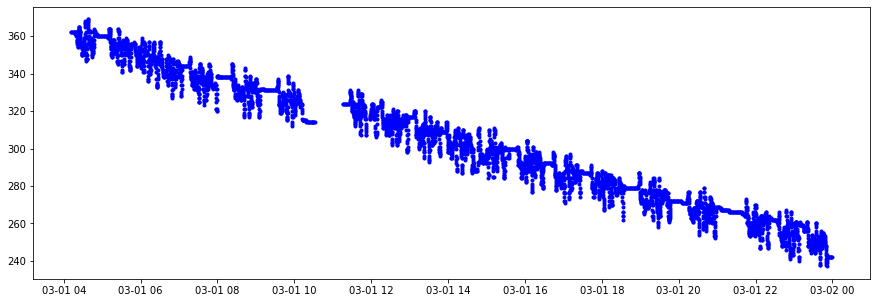

2019-03-02 02:38:00
2019-03-02 03:19:00


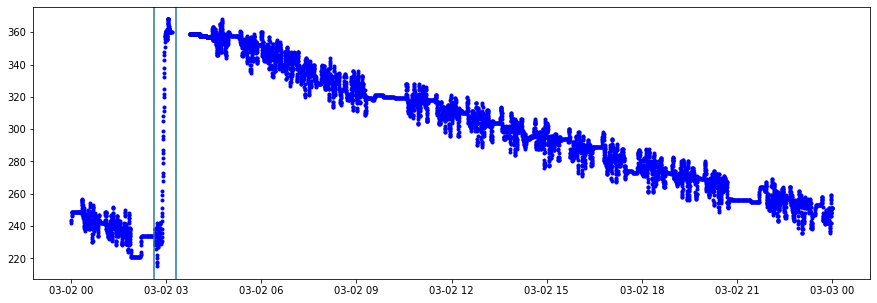

2019-03-03 02:00:00
2019-03-03 02:41:00


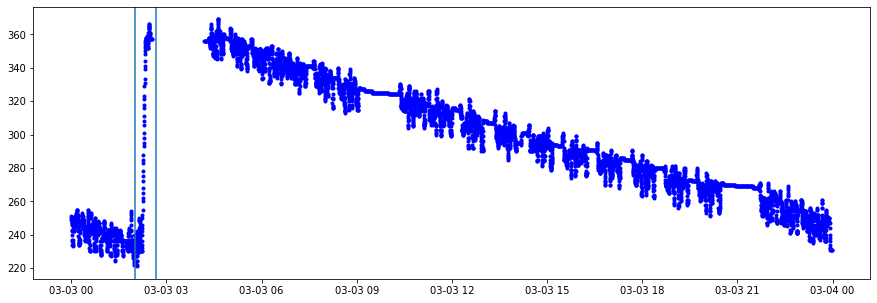

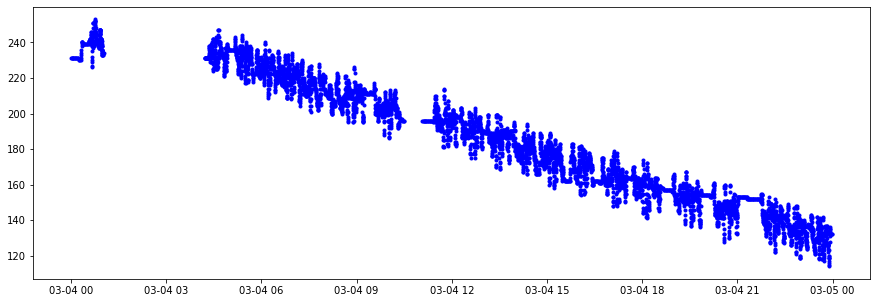

2019-03-05 01:55:00
2019-03-05 02:36:00


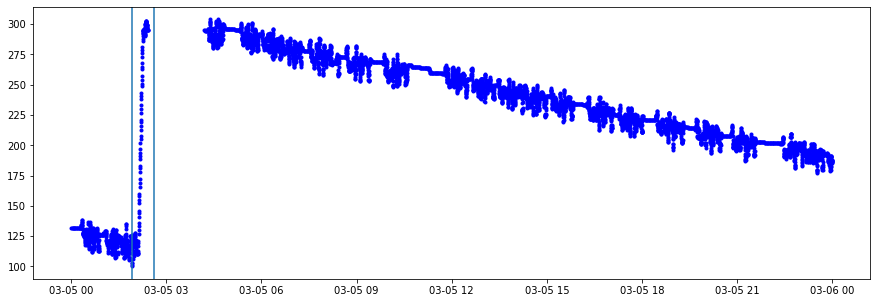

2019-03-06 03:21:00
2019-03-06 04:02:00


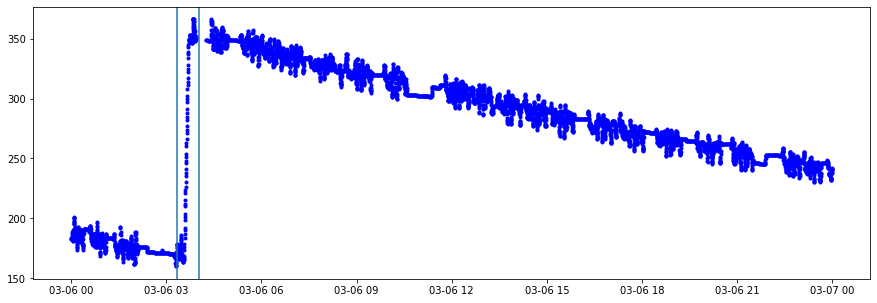

2019-03-07 02:08:00
2019-03-07 02:49:00


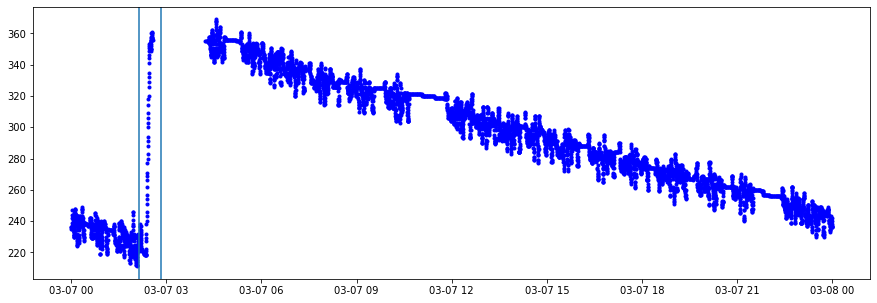

2019-03-08 02:41:00
2019-03-08 03:22:00


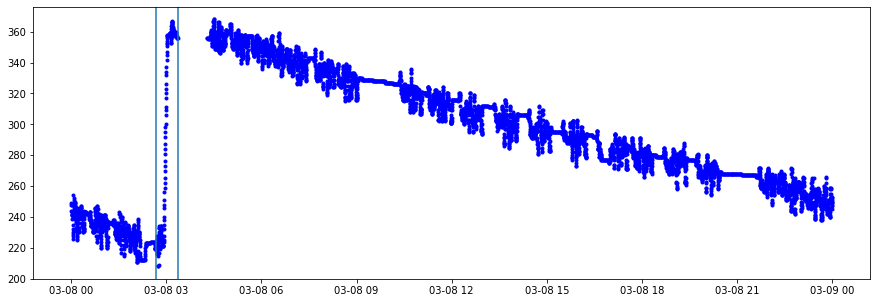

2019-03-09 00:21:00
2019-03-09 01:01:00


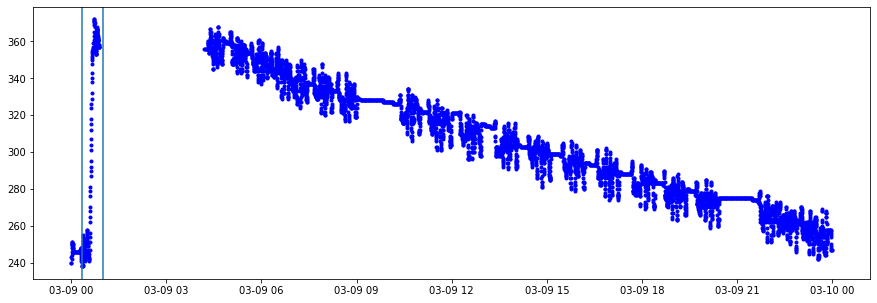

2019-03-10 00:50:00
2019-03-10 01:31:00


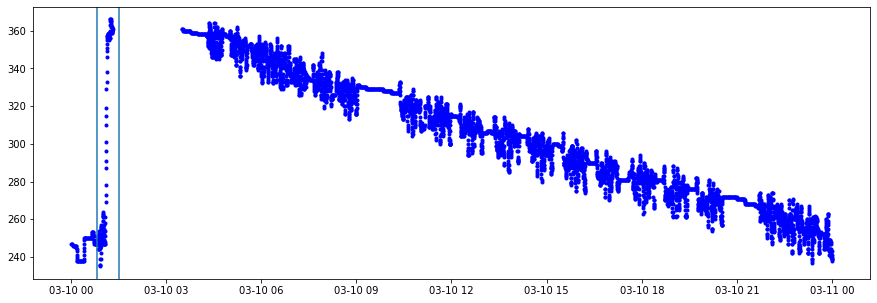

2019-03-11 00:16:00
2019-03-11 00:57:00


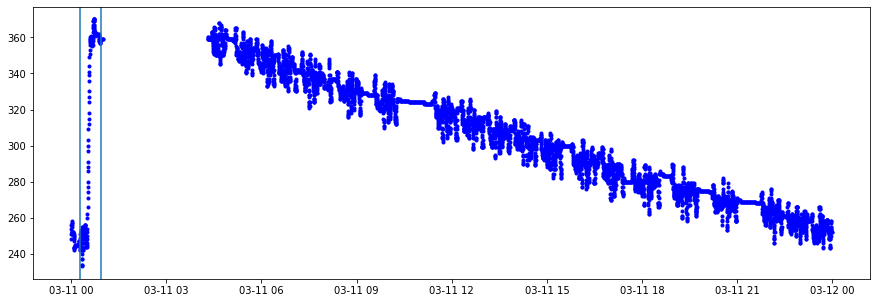

2019-03-12 02:02:00
2019-03-12 02:43:00


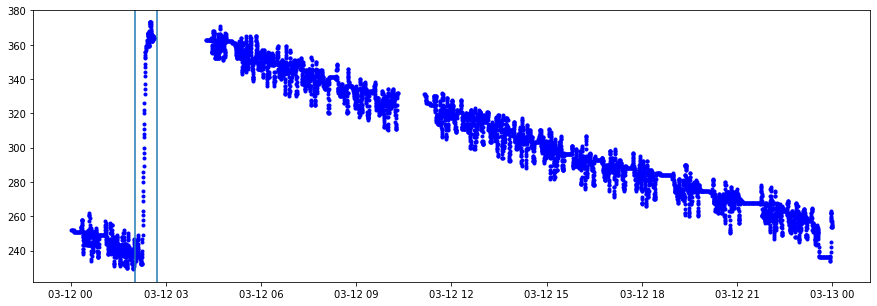

2019-03-13 01:53:00
2019-03-13 02:34:00


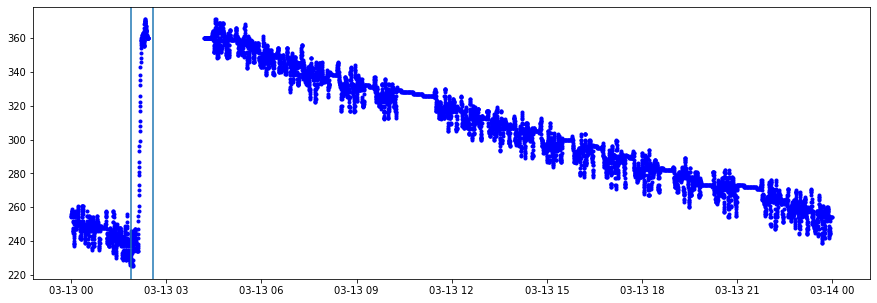

2019-03-14 02:57:00
2019-03-14 03:38:00


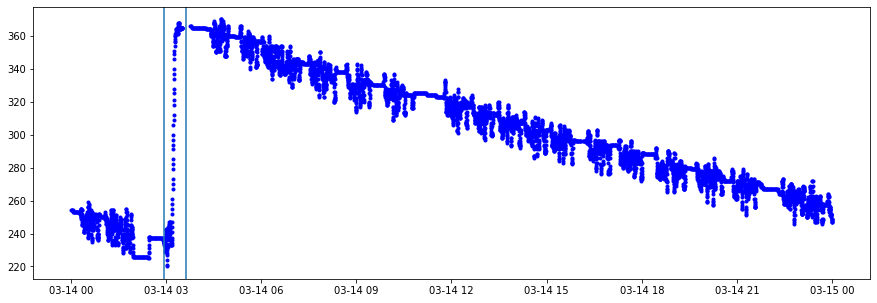

2019-03-15 02:06:00
2019-03-15 02:47:00


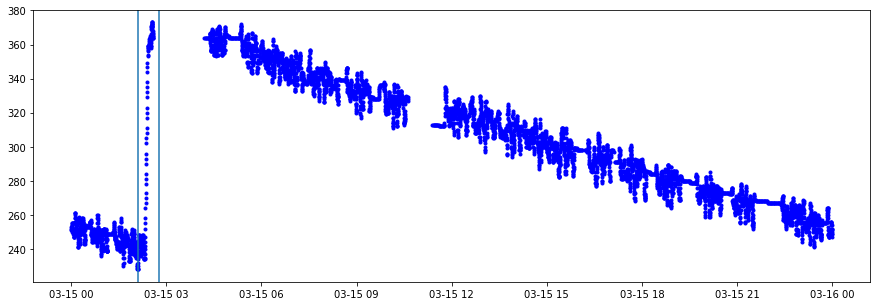

2019-03-16 04:05:00
2019-03-16 04:46:00


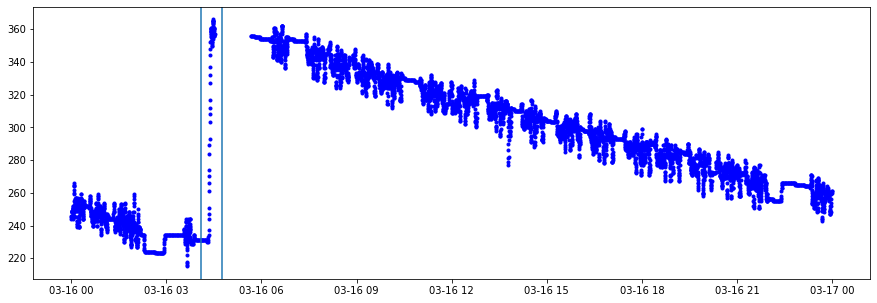

2019-03-17 02:05:00
2019-03-17 02:45:00


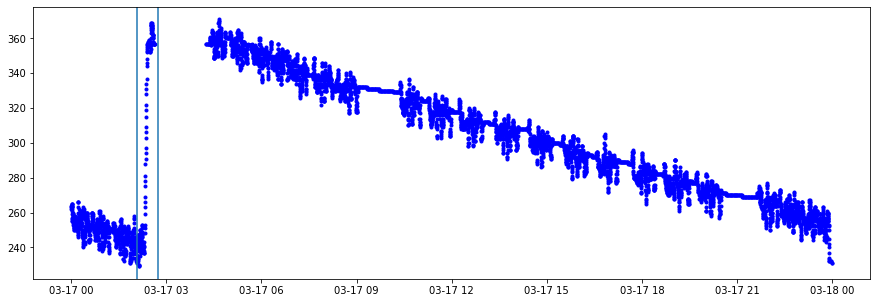

2019-03-18 00:31:00
2019-03-18 01:12:00


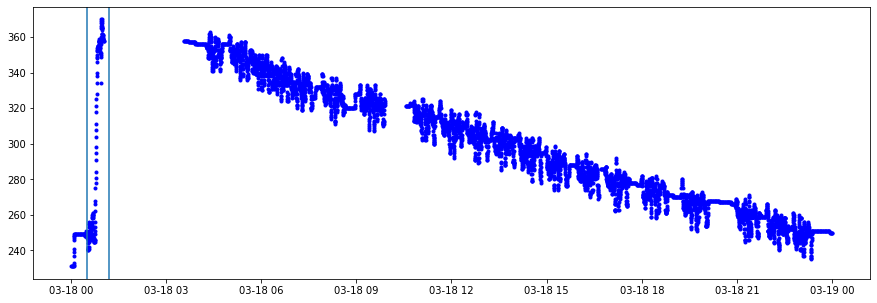

2019-03-19 01:35:00
2019-03-19 02:16:00


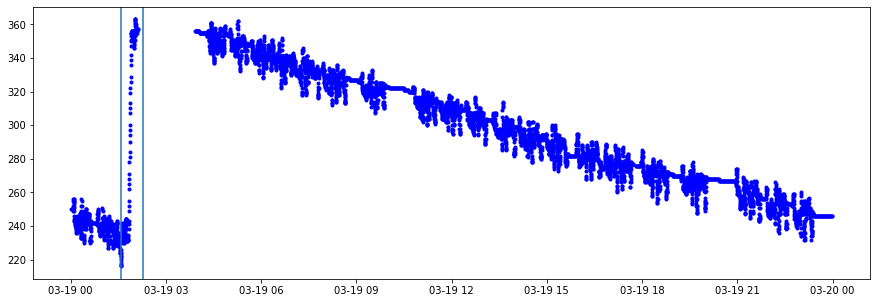

2019-03-20 03:03:00
2019-03-20 22:18:00
2019-03-20 03:44:00
2019-03-20 23:00:00


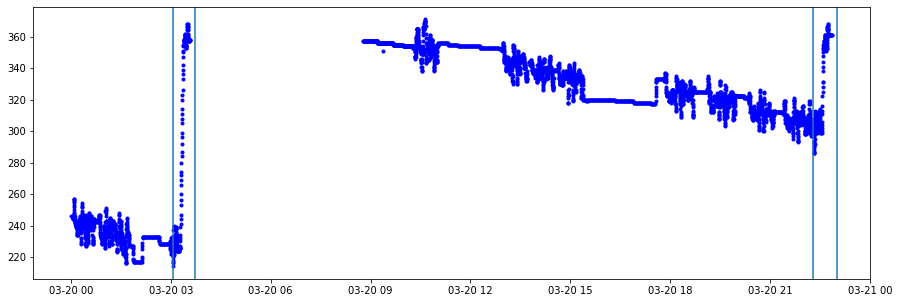

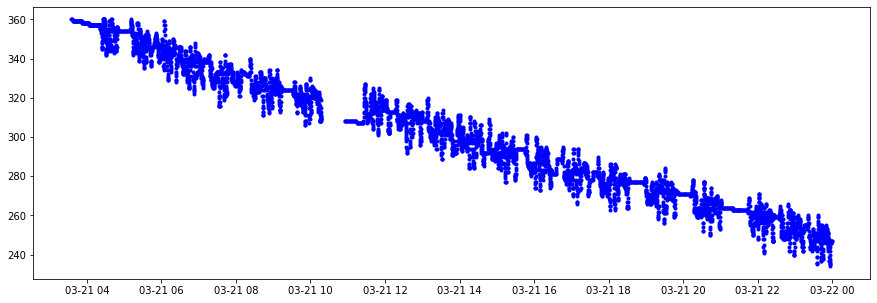

2019-03-22 02:37:00
2019-03-22 03:18:00


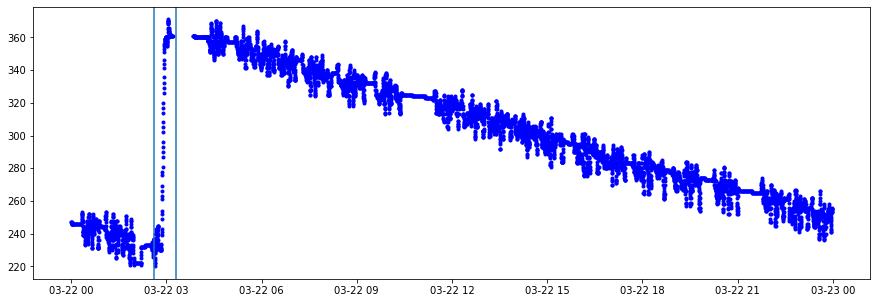

2019-03-23 01:52:00
2019-03-23 02:33:00


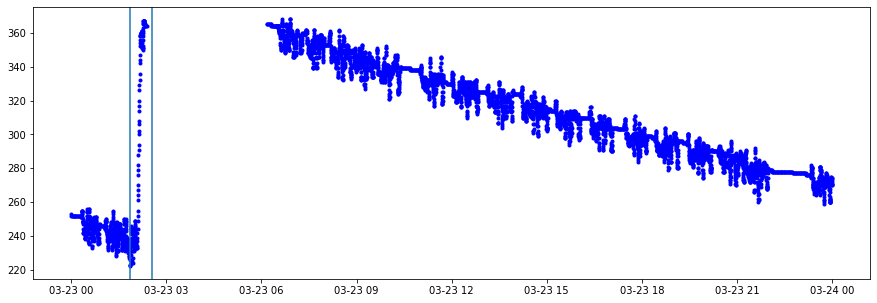

2019-03-24 03:21:00
2019-03-24 04:02:00


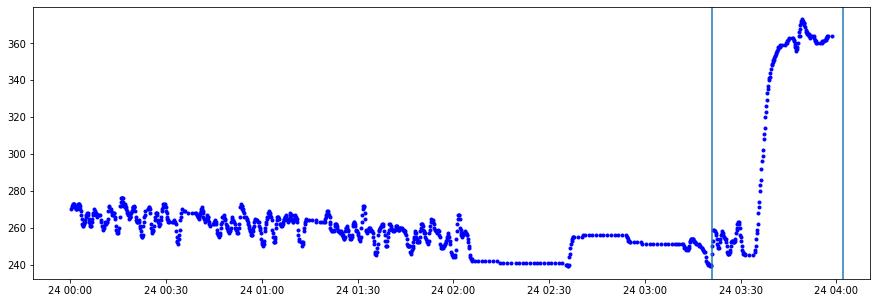

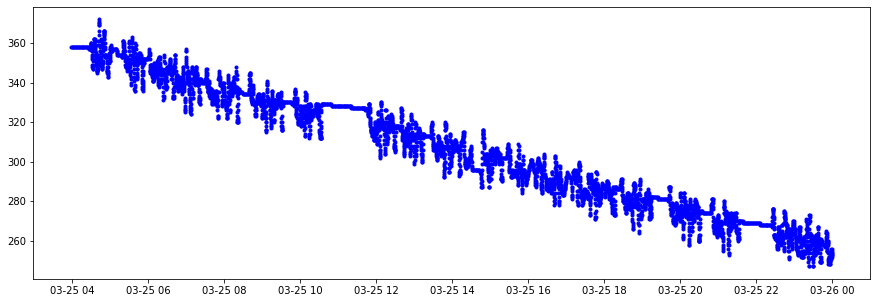

2019-03-26 03:03:00
2019-03-26 03:44:00


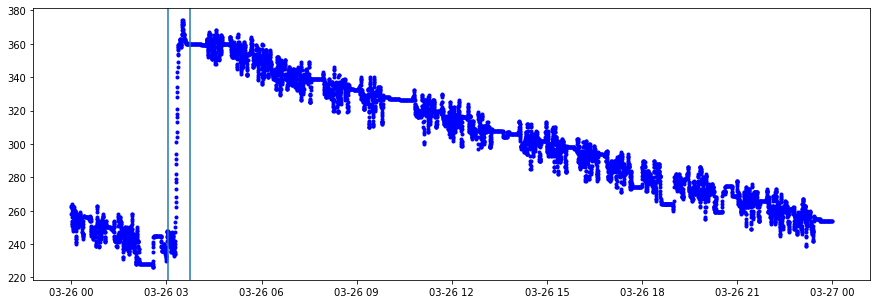

2019-03-27 01:34:00
2019-03-27 02:15:00


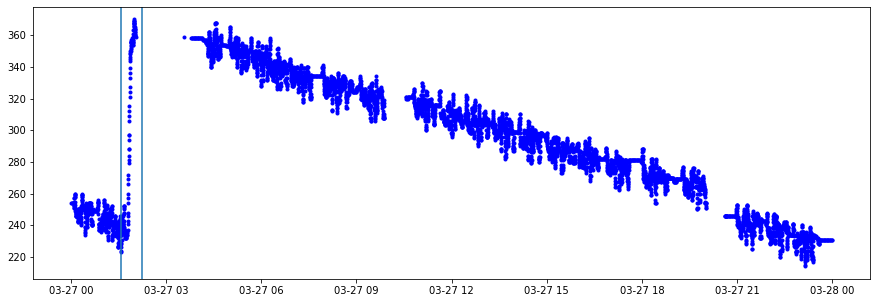

2019-03-28 01:57:00
2019-03-28 02:38:00


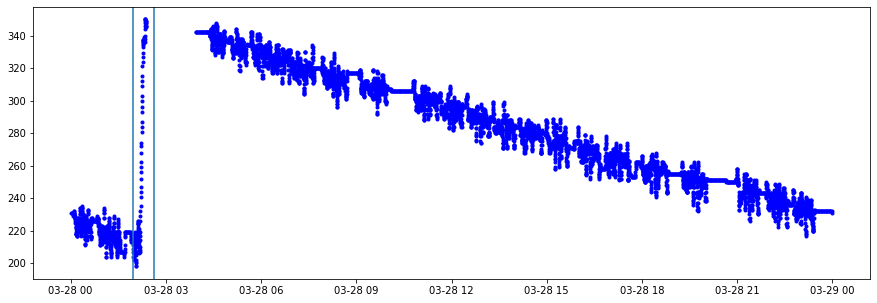

2019-03-29 01:38:00
2019-03-29 02:18:00


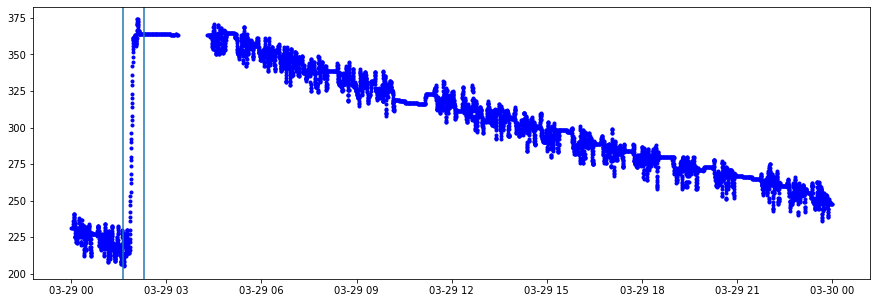

2019-03-30 02:43:00
2019-03-30 03:23:00


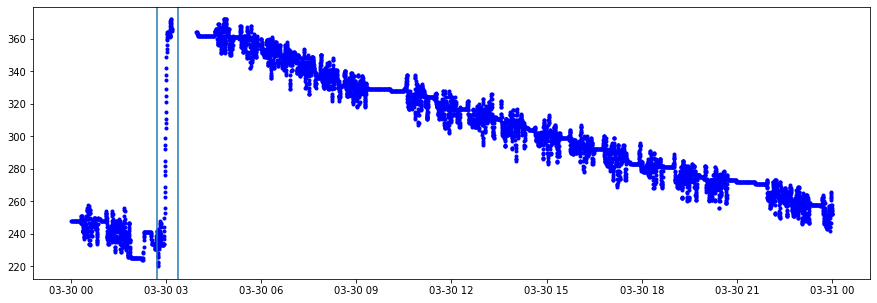

2019-03-31 01:44:00
2019-03-31 02:11:00


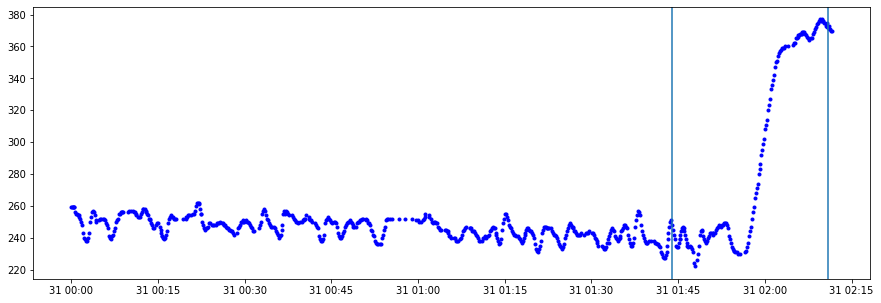

In [210]:
test_car_ = test_car.set_index('timestamp')
by_day = test_car_.groupby('day')
for g_name in by_day.groups:
    a = by_day.get_group(g_name)
    plt.figure(figsize=(15,5))
    plt.plot(a.index, a['liters'], 'b.')
        
    for i in idx_to_plot:
        if a.index.min()-pd.DateOffset(minutes=15) < i <a.index.max()+pd.DateOffset(minutes=15):
            print(i)
            plt.axvline(x=i)
            
    plt.show()

In [211]:
# create table with refills
start = norm_freq_ext.index.to_series()[refills_start.astype(int)].values
end = norm_freq_ext.index.to_series()[refills_end.astype(int)].values
data = [start,end]
refills = pd.DataFrame(data, index = ['start', 'end']).T.drop_duplicates().reset_index(drop=True)
liters = []
for i,r in refills.iterrows():
    slice_ = norm_freq_ext[r['start']:r['end']]
    liters.append(np.ptp(slice_['med_liters']))
refills['liters'] = liters
refills

,start,end,liters
0,2019-03-02 02:38:00,2019-03-02 03:19:00,125.0
1,2019-03-03 02:00:00,2019-03-03 02:41:00,116.0
2,2019-03-05 01:55:00,2019-03-05 02:36:00,170.0
3,2019-03-06 03:21:00,2019-03-06 04:02:00,177.0
4,2019-03-07 02:08:00,2019-03-07 02:49:00,124.0
5,2019-03-08 02:41:00,2019-03-08 03:22:00,129.0
6,2019-03-09 00:21:00,2019-03-09 01:01:00,105.0
7,2019-03-10 00:50:00,2019-03-10 01:31:00,111.0
8,2019-03-11 00:16:00,2019-03-11 00:57:00,107.0
9,2019-03-12 02:02:00,2019-03-12 02:43:00,119.0


# Find steals

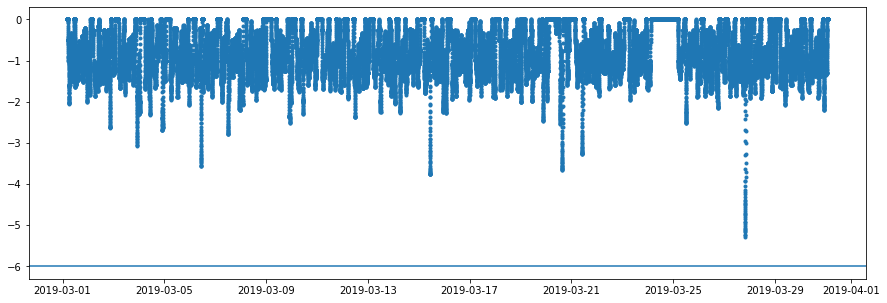

In [212]:
_derivative = derivative
_derivative[_derivative >0 ] = 0
plt.figure(figsize=(15,5))
plt.plot(norm_freq_ext.index, derivative[:], '.' )
plt.axhline(y=-6)
# for i in idx_to_plot:
#     plt.axvline(x=i)
plt.show()

In [218]:
peaks = sig.find_peaks(-derivative, 6 ,width = 10)

In [219]:
steal_start = peaks[1]['left_ips'] -10
steal_end = peaks[1]['right_ips'] -10

In [220]:
idx_to_plot = np.hstack([steal_start, steal_end]).astype(int)
idx_to_plot = norm_freq_ext.index.to_series()[idx_to_plot].drop_duplicates()

In [221]:
# debug plot
# norm_freq_ext['clean_sig'] = clean_sig
# by_day = norm_freq_ext.groupby('day')
# for g_name in by_day.groups:
#     a = by_day.get_group(g_name)
#     plt.figure(figsize=(15,5))
#     plt.plot(a.index, a['liters'], 'o')    
#     plt.plot(a.index, a['med_liters'], '.')    
#     plt.plot(a.index, a['clean_sig'], '.')

#     for i in idx_to_plot:
#         if a.index.min()-pd.DateOffset(minutes=15) < i <a.index.max()+pd.DateOffset(minutes=15):
#             plt.axvline(x=i)

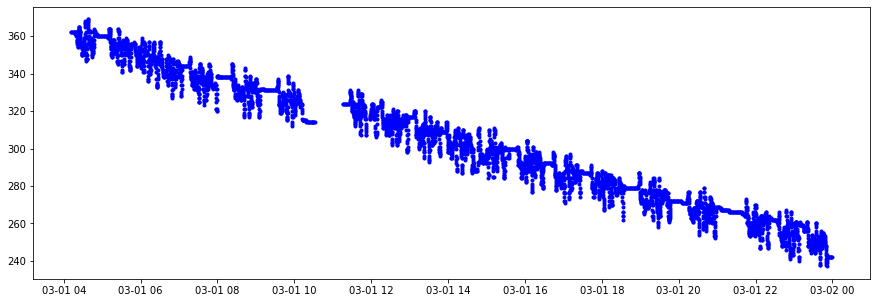

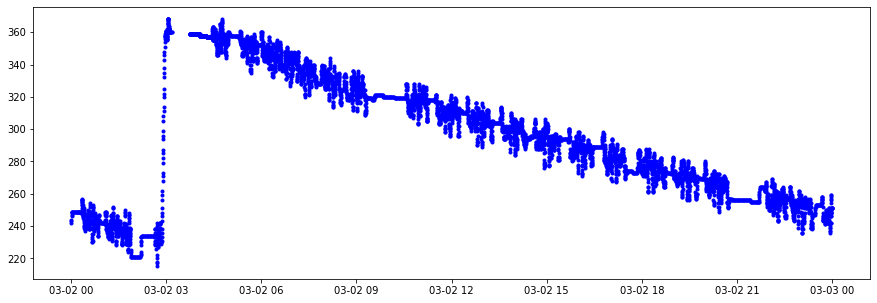

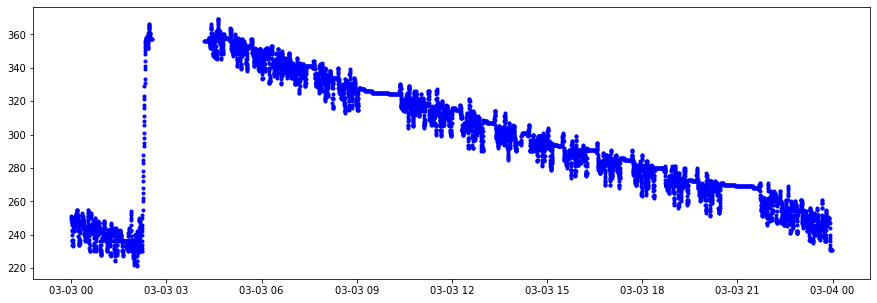

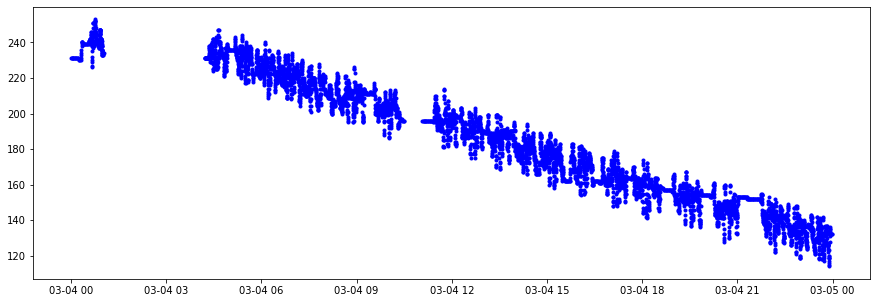

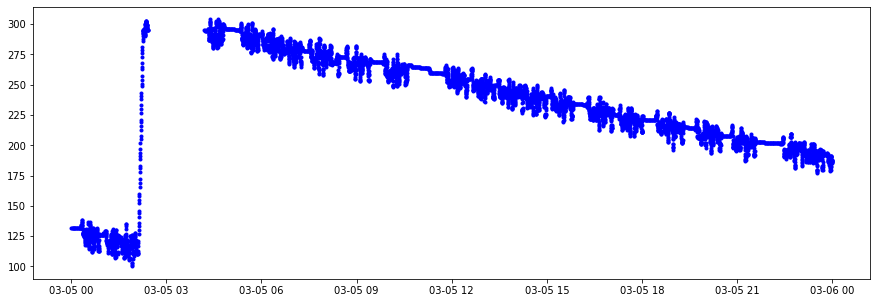

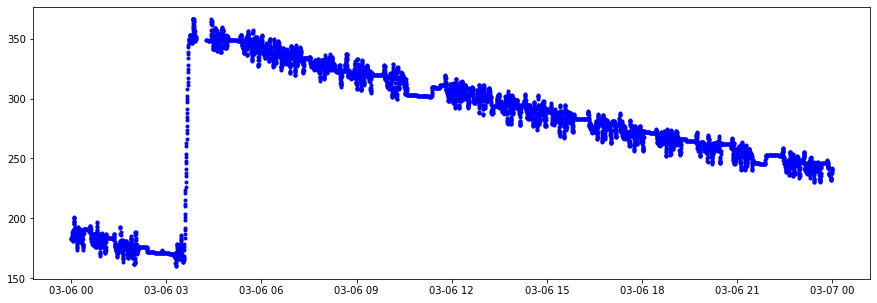

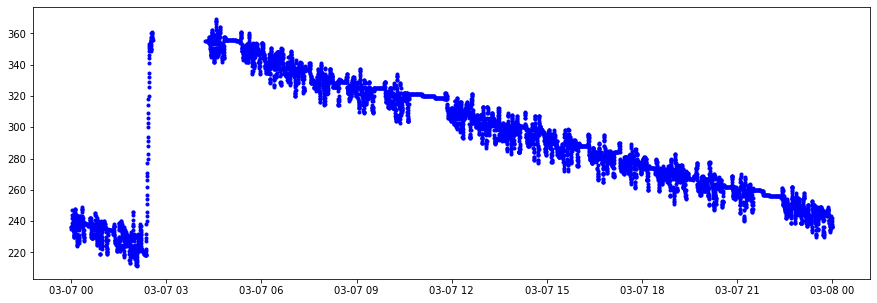

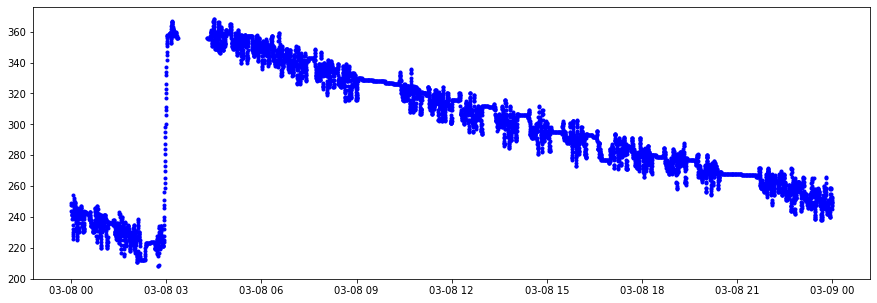

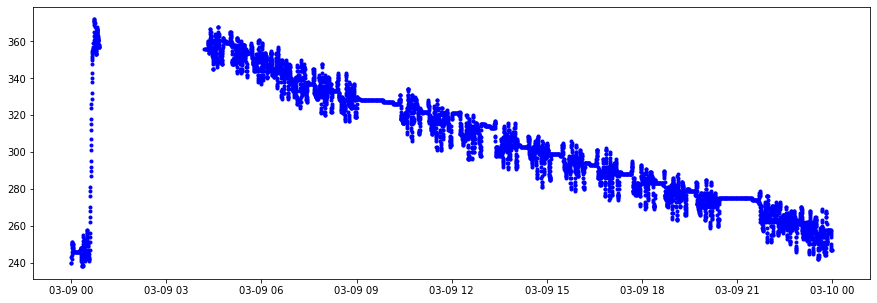

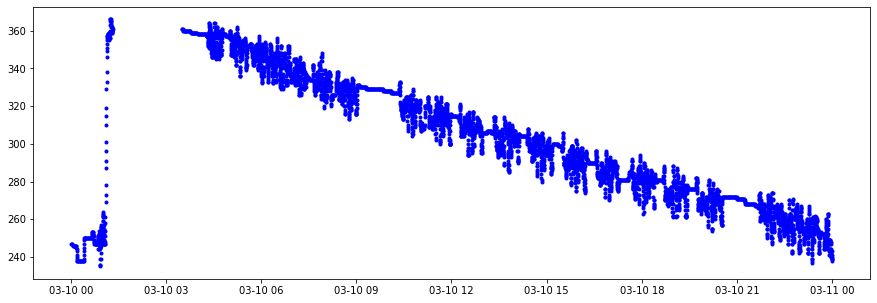

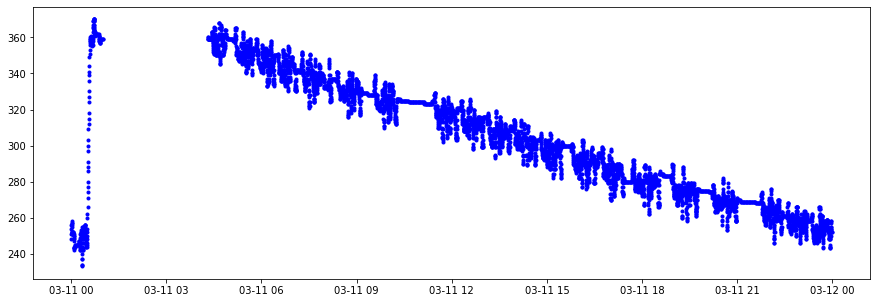

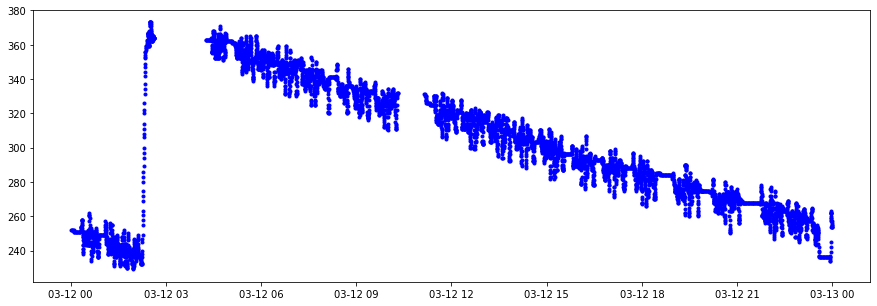

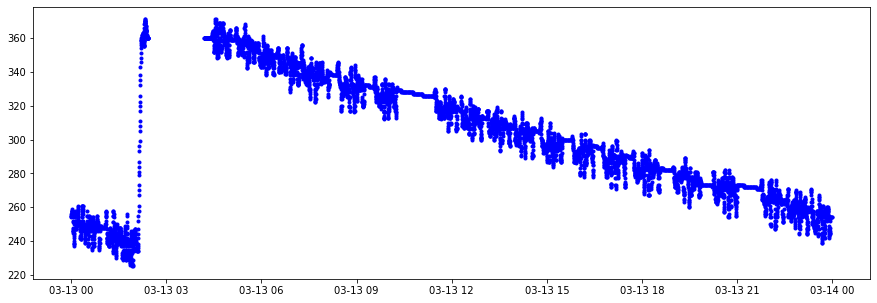

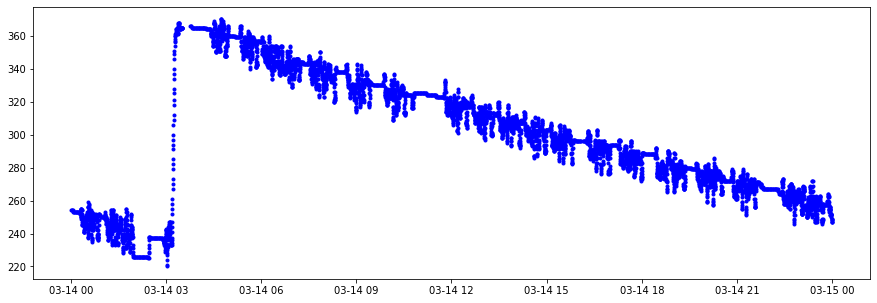

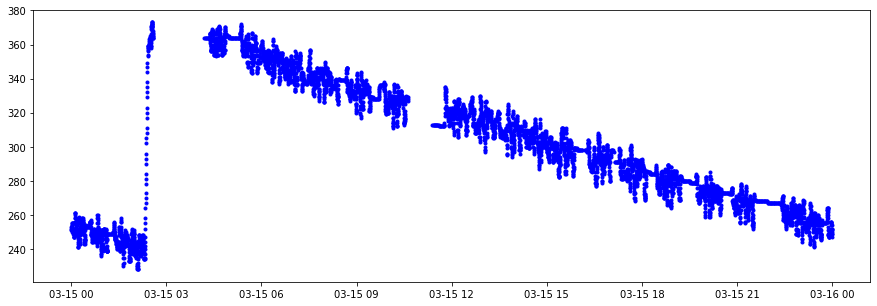

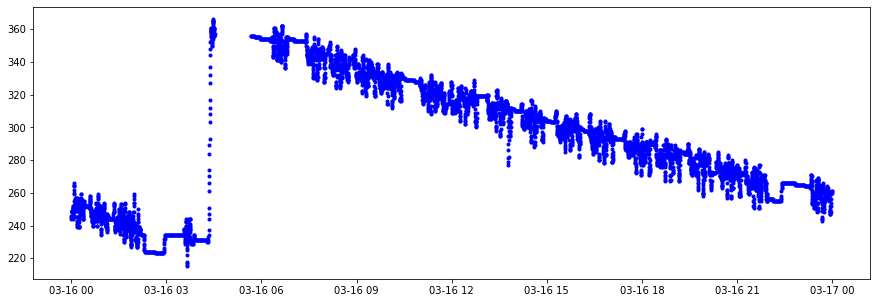

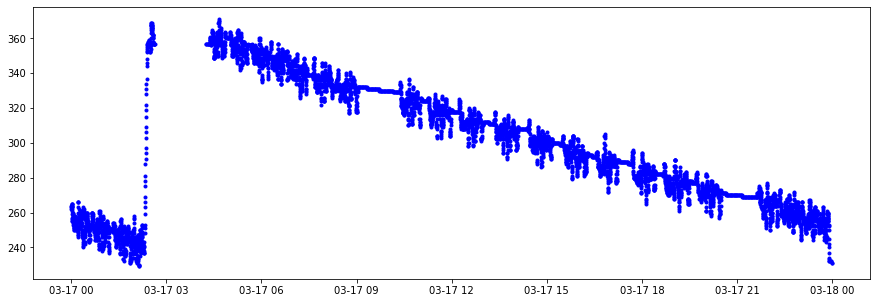

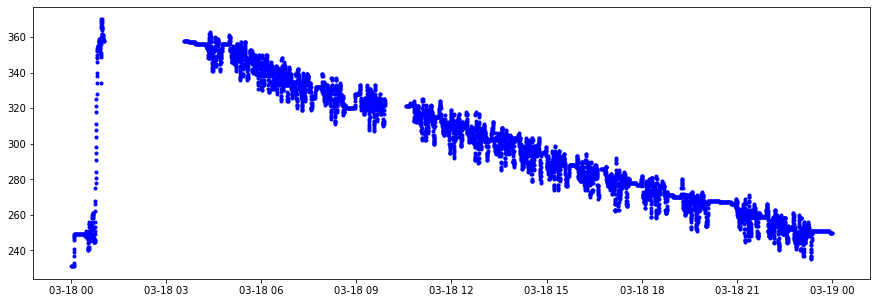

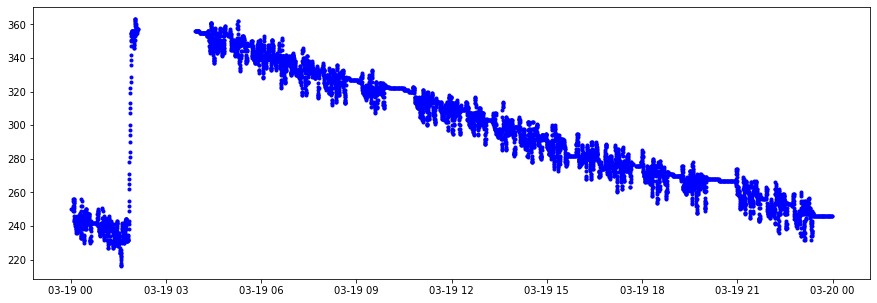

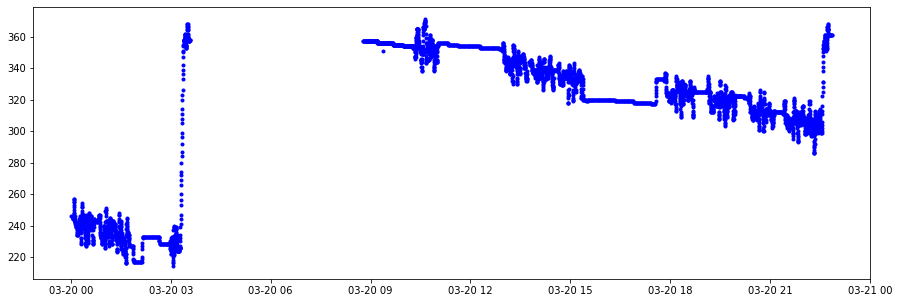

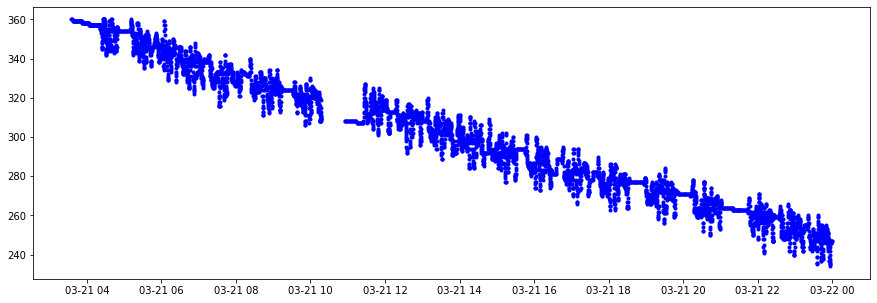

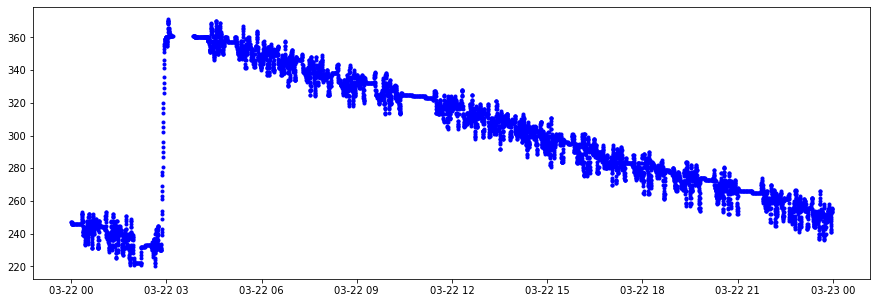

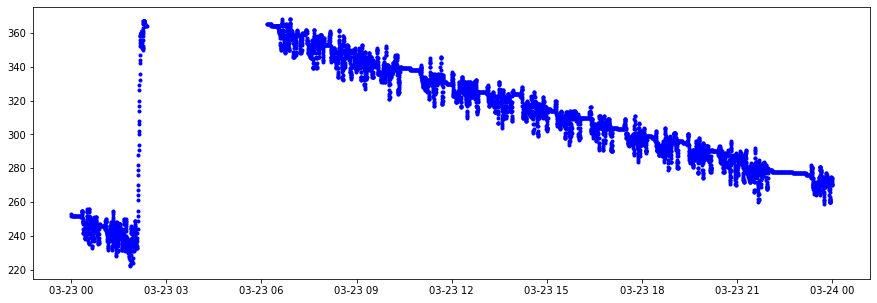

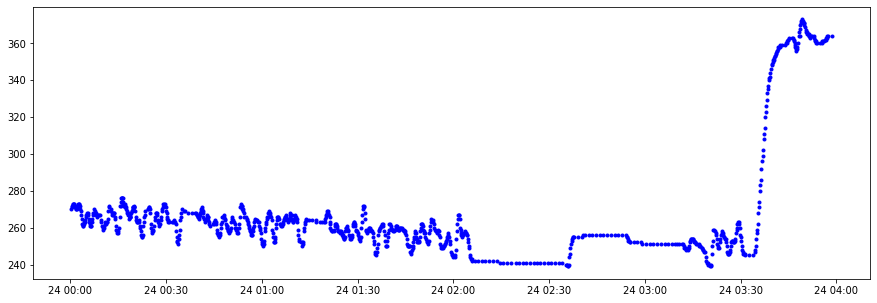

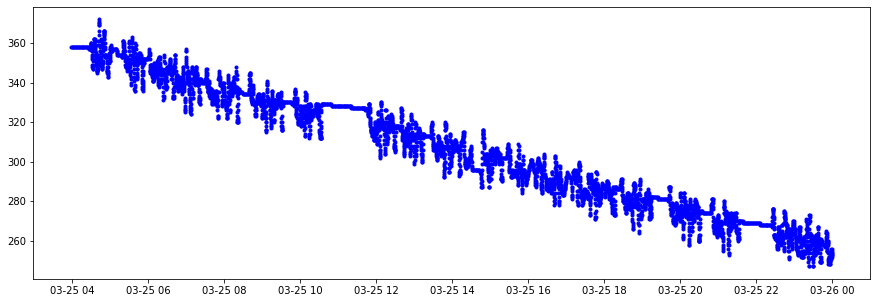

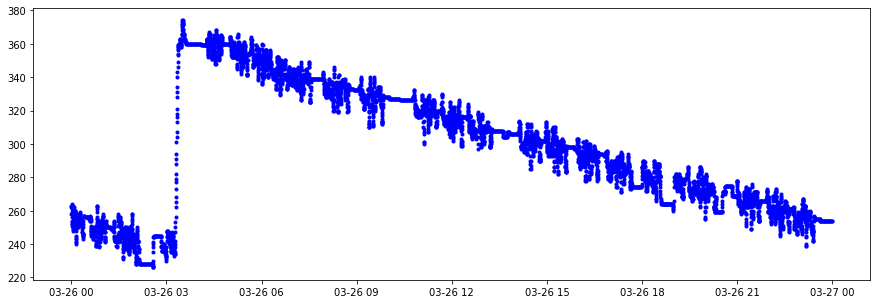

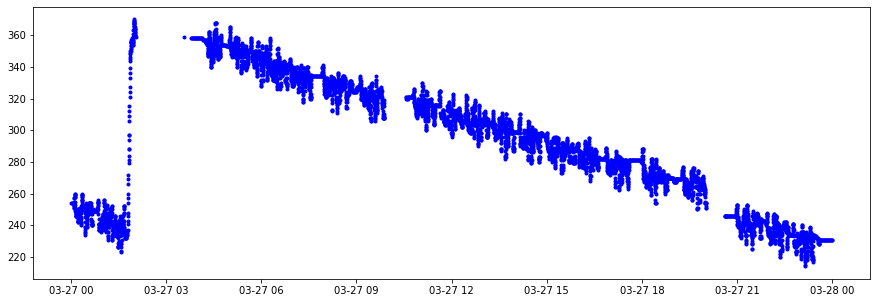

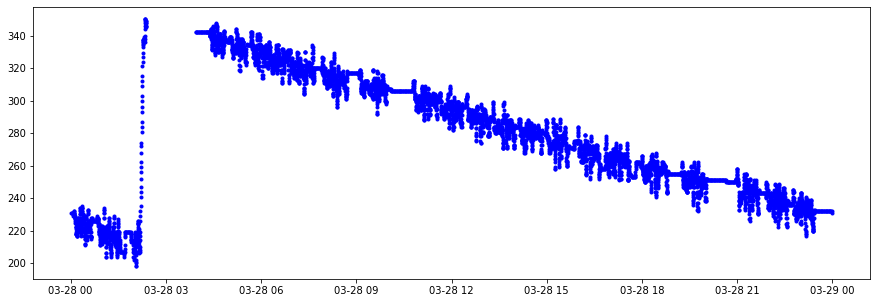

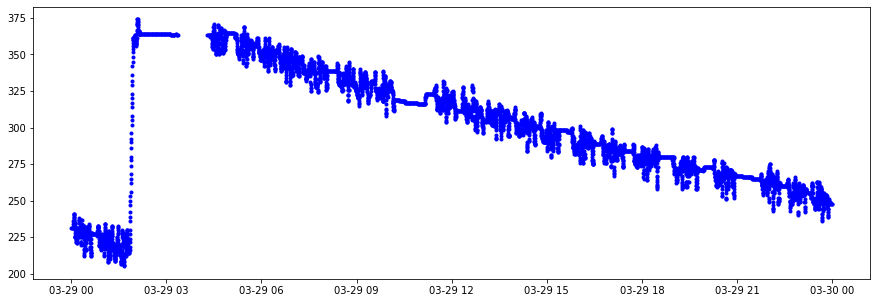

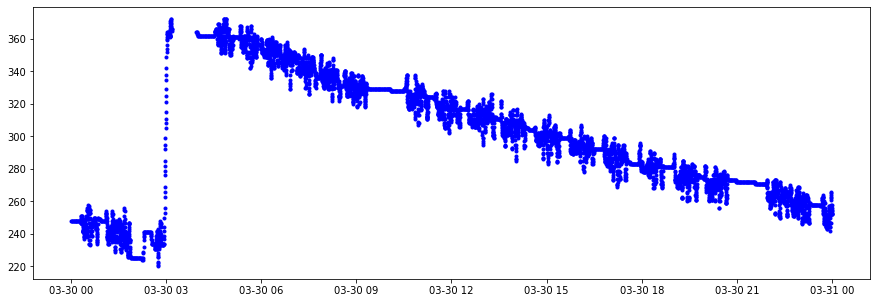

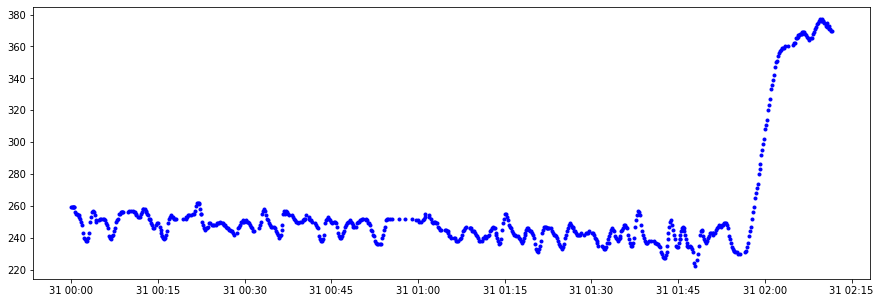

In [222]:
test_car_ = test_car.set_index('timestamp')
by_day = test_car_.groupby('day')
for g_name in by_day.groups:
    a = by_day.get_group(g_name)
    plt.figure(figsize=(15,5))
    plt.plot(a.index, a['liters'], 'b.')
        
    for i in idx_to_plot:
        if a.index.min()-pd.DateOffset(minutes=15) < i <a.index.max()+pd.DateOffset(minutes=15):
            print(i)
            plt.axvline(x=i)
            
    plt.show()

In [223]:
# create table with steals
start = norm_freq_ext.index.to_series()[steal_start.astype(int)].values
end = norm_freq_ext.index.to_series()[steal_end.astype(int)].values
data = [start,end]
steals = pd.DataFrame(data, index = ['start', 'end']).T.drop_duplicates().reset_index(drop=True)
liters = []
for i,r in steals.iterrows():
    slice_ = norm_freq_ext[r['start']:r['end']]
    liters.append(np.ptp(slice_['med_liters']))
steals['liters'] = liters
steals

,start,end,liters


# Find mean consumption

In [224]:
# insert start and end, invert periods, get len of slice and go
# min max diff and sum within a day
# drop refills
norm_freq_ext_ = norm_freq_ext.copy()
for i,r in refills.iterrows():
    norm_freq_ext_.drop(index=norm_freq_ext_.loc[r['start']:r['end']].index, inplace=True)
periods_gen = ((periods[i], periods[i+1]) for i in range(0, len(periods),2))
by_day = norm_freq_ext_.groupby('day')
p = next(periods_gen)
consumptions = []
for g_name in by_day.groups:
    a = by_day.get_group(g_name)    
    remain_len = len(a)
    day_consumption = 0
    bad_slices = []
    while True:
        slice_ = a.loc[p[0]:p[1], 'med_liters']
        if len(slice_) != 0:
            day_consumption += np.ptp(slice_)
            remain_len -= len(slice_)
            
        if remain_len != 0:
            p = next(periods_gen)
        else:
            consumptions.append(day_consumption)
            break

In [225]:
print('Среднесуточный расхо0д:', np.mean(consumptions))

Среднесуточный расхо0д: 109.58064516129032
